In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import json
from datetime import datetime
import sys
import pandas as pd
import json
import logging
import time


logger = logging.getLogger(__name__)
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("debug.log"),
        logging.StreamHandler(sys.stdout)
    ]
)

cutoff_time=0
output_dir="output/p1024_s128_rps5-p2048_s128_rps5-p4096_s128_rps5-maxtokens100-20250428_234418"
log_file =f"{output_dir}/gateway-plugins.log.csv"

In [2]:
def parse_log_file(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            # Check if this is a metrics line
            if "latency_metrics" not in line:
                logger.error(f"Invalid line. {line}")
                assert False
            if "**@" in line:
                line = line.split("**@latency_metrics@")[1]
            parts = line.split('@')
            row = {}
            json_columns = list()
            column_names = list()
            for i in range(0, len(parts), 2):
                column_name = parts[i]
                column_names.append(column_name)
                value = parts[i+1]
                if value.startswith('{') and value.endswith('}'):
                    try:
                        json_columns.append(column_name)
                        row[column_name] = json.loads(value) # this is going to be dictionary
                    except json.JSONDecodeError:
                        logger.error(f"Error decoding JSON: {value}")
                else:
                    try:
                        row[column_name] = int(value)
                    except ValueError:
                        try:
                            row[column_name] = float(value)
                        except ValueError:
                            row[column_name] = value
            data.append(row)
    def parse_json_columns(df, json_columns):
        for col in json_columns:
            if col in df.columns:
                df[col] = df[col].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
        return df
    df = pd.DataFrame(data, columns=column_names)
    df = parse_json_columns(df, json_columns)

    return df


ts = time.time()
df = parse_log_file(log_file)
print(f"parse_log_file took {time.time() - ts} seconds")

ts = time.time()
first_request_start_time = df['request_start_time'].min()
df['normalized_start_time'] = df['request_start_time'] - first_request_start_time
df['normalized_end_time'] = df['request_end_time'] - first_request_start_time
df['normalized_start_time'] /= 1_000_000
df['normalized_end_time'] /= 1_000_000
df['log_window_start_time'] = df['log_window_start_time'] - first_request_start_time
df['log_window_start_time'] /= 1_000_000
df['log_window_end_time'] = df['log_window_end_time'] - first_request_start_time
df['log_window_end_time'] /= 1_000_000
df = df[df['normalized_start_time'] > cutoff_time]
df['normalized_start_time'] = df['normalized_start_time'] - df['normalized_start_time'].min()
df['normalized_end_time'] = df['normalized_end_time'] - df['normalized_start_time'].min()
df = df.sort_values(by='normalized_start_time', ascending=True)
df['time_bucket'] = df['normalized_start_time'].astype(int)
df = df[['normalized_start_time', 'time_bucket', 'normalized_end_time'] + [col for col in df.columns if col != 'normalized_start_time' and col != 'normalized_end_time' and col != 'time_bucket']]
df.reset_index(drop=True, inplace=True)
print(f"time normalization took {time.time() - ts} seconds")

ts = time.time()
df.to_csv(f"{output_dir}/parsed-gateway-plugins.log.csv", index=False)
print(f"write to csv took {time.time() - ts} seconds")
# display(df.head())
# display(df.tail())
print(df["podMetricsLastSecond"][10].keys())
print(df["podMetricsLastSecond"][12].keys())
df

parse_log_file took 0.04580116271972656 seconds
time normalization took 0.006827116012573242 seconds
write to csv took 0.10012269020080566 seconds
dict_keys(['10.0.0.4', '10.0.1.19', '10.0.1.20', '10.0.1.3', '10.0.1.31', '10.0.3.12', '10.0.3.29', '10.0.3.41'])
dict_keys(['10.0.0.4', '10.0.1.19', '10.0.1.20', '10.0.1.3', '10.0.1.31', '10.0.3.12', '10.0.3.29', '10.0.3.41'])


,normalized_start_time,time_bucket,normalized_end_time,requestID,request_start_time,request_end_time,selectedpod,ttft,avg_tpot,total_decode_time,...,numTotalTokens,allPodsKvCacheHitRatios,numInflightRequestsAllPods,vllmGPUKVCacheUsage,vllmCPUKVCacheUsage,vllmNumRequestsRunning,vllmNumRequestsWaiting,podMetricsLastSecond,log_window_start_time,log_window_end_time
0,0.000000,0,2.435904,d53f93ac-f20e-4131-b7ae-65402d25cbc1,1745908894193338,1745908896387020,10.0.3.29,125,20,2068,...,3986,"{'10.0.0.4': 0, '10.0.1.19': 0, '10.0.1.20': 0...","{'10.0.1.20': 1, '10.0.3.29': 1}","{'10.0.0.4': 0, '10.0.1.19': 0, '10.0.1.20': 0...","{'10.0.0.4': 0, '10.0.1.19': 0, '10.0.1.20': 0...","{'10.0.0.4': 0, '10.0.1.19': 0, '10.0.1.20': 1...","{'10.0.0.4': 0, '10.0.1.19': 0, '10.0.1.20': 0...","{'10.0.0.4': {'avg_ttft_ms': -1, 'min_ttft_ms'...",1.435969,2.435969
1,0.182911,0,2.620449,51195e7d-71f8-421a-9cf2-7dad26ab5115,1745908894376249,1745908896571565,10.0.1.19,113,21,2081,...,2106,"{'10.0.0.4': 0, '10.0.1.19': 0, '10.0.1.20': 0...","{'10.0.1.19': 1, '10.0.1.20': 1, '10.0.3.29': 1}","{'10.0.0.4': 0, '10.0.1.19': 0, '10.0.1.20': 0...","{'10.0.0.4': 0, '10.0.1.19': 0, '10.0.1.20': 0...","{'10.0.0.4': 0, '10.0.1.19': 0, '10.0.1.20': 1...","{'10.0.0.4': 0, '10.0.1.19': 0, '10.0.1.20': 0...","{'10.0.0.4': {'avg_ttft_ms': -1, 'min_ttft_ms'...",1.620504,2.620504
2,0.347467,0,2.780801,bc626190-76db-4af7-98ff-f7ca75be0d07,1745908894540805,1745908896731917,10.0.1.19,113,20,2077,...,2108,"{'10.0.0.4': 0, '10.0.1.19': 0.937972768532526...","{'10.0.1.19': 2, '10.0.1.20': 1, '10.0.3.29': 1}","{'10.0.0.4': 0, '10.0.1.19': 0.009289295193158...","{'10.0.0.4': 0, '10.0.1.19': 0, '10.0.1.20': 0...","{'10.0.0.4': 0, '10.0.1.19': 1, '10.0.1.20': 1...","{'10.0.0.4': 0, '10.0.1.19': 0, '10.0.1.20': 0...","{'10.0.0.4': {'avg_ttft_ms': -1, 'min_ttft_ms'...",1.780856,2.780856
3,0.450644,0,2.880771,199274ee-21b1-4a16-94ee-66b553bf8e83,1745908894643982,1745908896831887,10.0.1.19,116,20,2071,...,2103,"{'10.0.0.4': 0, '10.0.1.19': 0.942871587462082...","{'10.0.1.19': 3, '10.0.1.20': 1, '10.0.3.29': 1}","{'10.0.0.4': 0, '10.0.1.19': 0.010026540843409...","{'10.0.0.4': 0, '10.0.1.19': 0, '10.0.1.20': 0...","{'10.0.0.4': 0, '10.0.1.19': 2, '10.0.1.20': 1...","{'10.0.0.4': 0, '10.0.1.19': 0, '10.0.1.20': 0...","{'10.0.0.4': {'avg_ttft_ms': -1, 'min_ttft_ms'...",1.880829,2.880828
4,0.659100,0,3.036866,0fcd656a-6c2b-4018-aaa3-4c85803c9cd9,1745908894852438,1745908896987982,10.0.1.20,113,20,2022,...,1188,"{'10.0.0.4': 0, '10.0.1.19': 0.003762935089369...","{'10.0.1.19': 3, '10.0.1.20': 2, '10.0.3.29': 1}","{'10.0.0.4': 0, '10.0.1.19': 0.010690061928634...","{'10.0.0.4': 0, '10.0.1.19': 0, '10.0.1.20': 0...","{'10.0.0.4': 0, '10.0.1.19': 3, '10.0.1.20': 1...","{'10.0.0.4': 0, '10.0.1.19': 0, '10.0.1.20': 0...","{'10.0.0.4': {'avg_ttft_ms': -1, 'min_ttft_ms'...",2.036923,3.036923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,162.061379,162,164.440489,f2f9a3ae-1c15-4219-acb9-447eb074400c,1745909056254717,1745909058391605,10.0.1.19,137,20,1999,...,2107,"{'10.0.0.4': 0, '10.0.1.19': 0.940968718466195...","{'10.0.1.19': 3, '10.0.1.20': 8, '10.0.3.29': 2}","{'10.0.0.4': 0, '10.0.1.19': 0.010690061928634...","{'10.0.0.4': 0, '10.0.1.19': 0, '10.0.1.20': 0...","{'10.0.0.4': 0, '10.0.1.19': 2, '10.0.1.20': 8...","{'10.0.0.4': 0, '10.0.1.19': 0, '10.0.1.20': 0...","{'10.0.0.4': {'avg_ttft_ms': -1, 'min_ttft_ms'...",163.440567,164.440567
795,162.156664,162,164.577765,1c8871f8-2cf8-426c-b090-505ee8e6ff66,1745909056350002,1745909058528881,10.0.1.20,131,20,2046,...,1190,"{'10.0.0.4': 0, '10.0.1.19': 0.003755868544600...","{'10.0.1.19': 3, '10.0.1.20': 9, '10.0.3.29': 2}","{'10.0.0.4': 0, '10.0.1.19': 0.011353583013860...","{'10.0.0.4': 0, '10.0.1.19': 0, '10.0.1.20': 0...","{'10.0.0.4': 0, '10.0.1.19': 3, '10.0.1.20': 8...","{'10.0.0.4': 0, '10.0.1.19': 0, '10.0.1.20': 0...","{'10.0.0.4': {'avg_ttft_ms': -1, 'min_ttft_ms'...",163.577827,164.577827
796,1

In [3]:
def analyze_llm_inference_logs(df):
    if df.empty:
        print("No valid data found in the log file.")
        return
    
    print("Available columns:", df.columns)
    
    # Basic statistics
    print(f"Total requests: {len(df)}")
    
    # Calculate experiment duration
    if 'request_start_time' in df.columns and 'request_end_time' in df.columns:
        start_time = df['request_start_time'].min()
        end_time = df['request_end_time'].max()
        print(f"Experiment duration: {(end_time - start_time) / 1000000:.2f} seconds")
    else:
        print("Start and end time columns not found.")
    
    df['selectedpod'] = df['selectedpod'].str.split(':').str[0]

    # Process KV cache hit ratios
    if 'allPodsKvCacheHitRatios' in df.columns:
        df['selected_pod_kv_cache_hit_ratio'] = df.apply(
            lambda row: row['allPodsKvCacheHitRatios'].get(row['selectedpod'], 0) 
            if isinstance(row['allPodsKvCacheHitRatios'], dict) else 0, 
            axis=1
        )
    
    # Process GPU KV cache usage
    if 'vllmGPUKVCacheUsage' in df.columns:
        df['selected_pod_vllm_gpu_kv_cache_usage'] = df.apply(
            lambda row: row['vllmGPUKVCacheUsage'].get(row['selectedpod'], 0) 
            if isinstance(row['vllmGPUKVCacheUsage'], dict) else 0, 
            axis=1
        )
    
    # Process CPU KV cache usage
    if 'vllmCPUKVCacheUsage' in df.columns:
        df['selected_pod_vllm_cpu_kv_cache_usage'] = df.apply(
            lambda row: row['vllmCPUKVCacheUsage'].get(row['selectedpod'], 0) 
            if isinstance(row['vllmCPUKVCacheUsage'], dict) else 0, 
            axis=1
        )
    
    # Process inflight requests
    if 'numInflightRequestsAllPods' in df.columns:
        df['total_num_inflight_requests'] = df.apply(
            lambda row: sum(row['numInflightRequestsAllPods'].values()) 
            if isinstance(row['numInflightRequestsAllPods'], dict) else 0, 
            axis=1
        )
        df['selected_pod_num_inflight_requests'] = df.apply(
            lambda row: row['numInflightRequestsAllPods'].get(row['selectedpod'], 0) 
            if isinstance(row['numInflightRequestsAllPods'], dict) else 0, 
            axis=1
        )
    
    # Process running requests
    if 'vllmNumRequestsRunning' in df.columns:
        df['total_vllm_num_running_requests'] = df.apply(
            lambda row: sum(row['vllmNumRequestsRunning'].values()) 
            if isinstance(row['vllmNumRequestsRunning'], dict) else 0, 
            axis=1
        )
        df['selected_pod_num_running_requests'] = df.apply(
            lambda row: row['vllmNumRequestsRunning'].get(row['selectedpod'], 0) 
            if isinstance(row['vllmNumRequestsRunning'], dict) else 0, 
            axis=1
        )
    
    # Process waiting requests
    if 'vllmNumRequestsWaiting' in df.columns:
        df['total_vllm_num_waiting_requests'] = df.apply(
            lambda row: sum(row['vllmNumRequestsWaiting'].values()) 
            if isinstance(row['vllmNumRequestsWaiting'], dict) else 0, 
            axis=1
        )
        df['selected_pod_num_waiting_requests'] = df.apply(
            lambda row: row['vllmNumRequestsWaiting'].get(row['selectedpod'], 0) 
            if isinstance(row['vllmNumRequestsWaiting'], dict) else 0, 
            axis=1
        )
    
    # Map column names from new format to old format
    column_mapping = {
        'ttft': 'gateway_side_ttft',
        'avg_tpot': 'gateway_side_tpot',
        'e2e': 'gateway_side_e2e_latency',
        'numInputTokens': 'prompt_tokens',
        'numOutputTokens': 'output_tokens',
        'numTotalTokens': 'total_tokens'
    }
    
    # Rename columns
    for old_col, new_col in column_mapping.items():
        if old_col in df.columns:
            df[new_col] = df[old_col]
    
    # Create plots as in the original script    
    return df

def analyze_pod_metrics_last_second(df):
    """Extract and analyze pod metrics from the last second window"""
    
    if 'podMetricsLastSecond' not in df.columns:
        print("No pod metrics last second data found in the DataFrame")
        return df
    
    # Initialize new columns for the selected pod metrics
    metrics_to_extract = [
        'avg_ttft_ms', 'min_ttft_ms', 'max_ttft_ms', 'p50_ttft_ms', 'p90_ttft_ms', 'p95_ttft_ms', 'p99_ttft_ms',
        'avg_tpot_ms', 'min_tpot_ms', 'max_tpot_ms', 'p50_tpot_ms', 'p90_tpot_ms', 'p95_tpot_ms', 'p99_tpot_ms',
        'early_tokens_tpot_ms', 'mid_tokens_tpot_ms', 'late_tokens_tpot_ms',
        'ttft_samples', 'tpot_samples', 'total_requests', 'total_tokens'
    ]
    
    for metric in metrics_to_extract:
        df[f'selected_pod_{metric}'] = None
    
    # Also calculate cluster-wide averages
    for metric in metrics_to_extract:
        df[f'cluster_avg_{metric}'] = None
    
    # Process each row
    for idx, row in df.iterrows():
        selected_pod = row['selectedpod']
        pod_metrics = row['podMetricsLastSecond']
        
        # Extract selected pod metrics
        if selected_pod in pod_metrics:
            for metric in metrics_to_extract:
                if metric in pod_metrics[selected_pod]:
                    df.at[idx, f'selected_pod_{metric}'] = pod_metrics[selected_pod][metric]
        
        # Calculate cluster-wide averages for numeric metrics
        for metric in metrics_to_extract:
            values = []
            for pod, metrics in pod_metrics.items():
                if metric in metrics and isinstance(metrics[metric], (int, float)) and metrics[metric] > 0:
                    values.append(metrics[metric])
            
            if values:
                df.at[idx, f'cluster_avg_{metric}'] = sum(values) / len(values)
    
    # Calculate additional metrics
    # TTFT variance across cluster
    df['ttft_variance_across_cluster'] = df.apply(
        lambda row: calculate_variance(row['podMetricsLastSecond'], 'avg_ttft_ms'),
        axis=1
    )
    
    # TPOT variance across cluster
    df['tpot_variance_across_cluster'] = df.apply(
        lambda row: calculate_variance(row['podMetricsLastSecond'], 'avg_tpot_ms'),
        axis=1
    )
    
    # Total active pods (pods handling requests)
    df['active_pods_count'] = df.apply(
        lambda row: sum(1 for pod, metrics in row['podMetricsLastSecond'].items() 
                      if 'total_requests' in metrics and metrics['total_requests'] > 0),
        axis=1
    )
    
    return df

def calculate_variance(pod_metrics, metric_name):
    """Calculate variance of a metric across all pods"""
    values = []
    for pod, metrics in pod_metrics.items():
        if metric_name in metrics and isinstance(metrics[metric_name], (int, float)) and metrics[metric_name] > 0:
            values.append(metrics[metric_name])
    
    if len(values) <= 1:
        return 0
    
    mean = sum(values) / len(values)
    variance = sum((x - mean)**2 for x in values) / len(values)
    return variance

df = analyze_llm_inference_logs(df)
df = analyze_pod_metrics_last_second(df)

Available columns: Index(['normalized_start_time', 'time_bucket', 'normalized_end_time',
       'requestID', 'request_start_time', 'request_end_time', 'selectedpod',
       'ttft', 'avg_tpot', 'total_decode_time', 'e2e', 'numInputTokens',
       'numOutputTokens', 'numTotalTokens', 'allPodsKvCacheHitRatios',
       'numInflightRequestsAllPods', 'vllmGPUKVCacheUsage',
       'vllmCPUKVCacheUsage', 'vllmNumRequestsRunning',
       'vllmNumRequestsWaiting', 'podMetricsLastSecond',
       'log_window_start_time', 'log_window_end_time'],
      dtype='object')
Total requests: 799
Experiment duration: 164.63 seconds


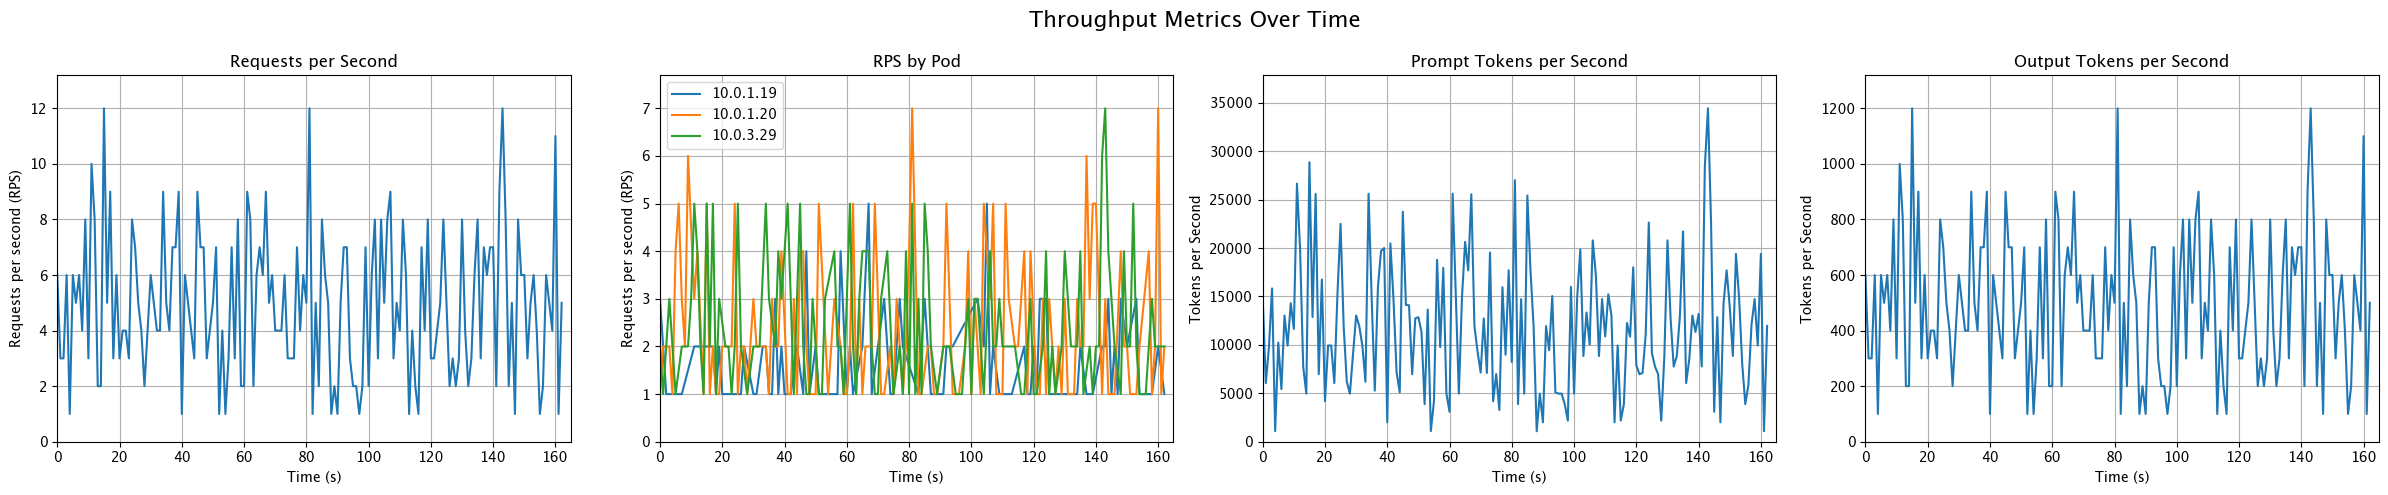

In [4]:
def create_simple_rps_plots(df):
    """Create simplified RPS (Requests Per Second) plots with all subfigures in one row"""
    
    # Determine which plots we can create based on available columns
    plots_to_create = []
    
    if 'normalized_start_time' in df.columns:
        plots_to_create.append('rps')
    
    if 'normalized_start_time' in df.columns and 'selectedpod' in df.columns:
        plots_to_create.append('pod_rps')
    
    if 'normalized_start_time' in df.columns and 'prompt_tokens' in df.columns:
        plots_to_create.append('prompt_tps')
    
    if 'normalized_start_time' in df.columns and 'output_tokens' in df.columns:
        plots_to_create.append('output_tps')
    
    if not plots_to_create:
        return
    
    df_copy = df.copy()    
    # Get max time for consistent x-axis limits
    max_time = df_copy['normalized_end_time'].max() if 'normalized_end_time' in df_copy.columns else None
    if max_time is not None and np.isnan(max_time):
        max_time = None
    
    # Create subplots in a single row
    fig, axes = plt.subplots(1, len(plots_to_create), figsize=(6*len(plots_to_create), 5))
    fig.suptitle('Throughput Metrics Over Time', fontsize=16)
    
    # Make axes iterable if only one plot
    if len(plots_to_create) == 1:
        axes = [axes]
    
    # Create each plot
    for i, plot_type in enumerate(plots_to_create):
        ax = axes[i]
        
        if plot_type == 'rps':
            # Basic RPS plot
            rps = df_copy.groupby('time_bucket').size().reset_index(name='count')
            ax.plot(rps['time_bucket'], rps['count'])
            ax.set_title('Requests per Second')
            ax.set_ylabel('Requests per second (RPS)')
            if len(rps) > 0:
                ax.set_ylim(0, rps['count'].max() * 1.1)
                
        elif plot_type == 'pod_rps':
            # RPS by pod
            pod_rps = df_copy.groupby(['time_bucket', 'selectedpod']).size().reset_index(name='count')
            for pod in pod_rps['selectedpod'].unique():
                pod_data = pod_rps[pod_rps['selectedpod'] == pod]
                ax.plot(pod_data['time_bucket'], pod_data['count'], label=pod)
            ax.set_title('RPS by Pod')
            ax.set_ylabel('Requests per second (RPS)')
            ax.legend()
            if len(pod_rps) > 0:
                ax.set_ylim(0, pod_rps['count'].max() * 1.1)
                
        elif plot_type == 'prompt_tps':
            # Prompt tokens per second
            prompt_tps = df_copy.groupby('time_bucket')['prompt_tokens'].sum().reset_index(name='count')
            ax.plot(prompt_tps['time_bucket'], prompt_tps['count'])
            ax.set_title('Prompt Tokens per Second')
            ax.set_ylabel('Tokens per Second')
            if len(prompt_tps) > 0:
                ax.set_ylim(0, prompt_tps['count'].max() * 1.1)
                
        elif plot_type == 'output_tps':
            # Output tokens per second
            output_tps = df_copy.groupby('time_bucket')['output_tokens'].sum().reset_index(name='count')
            ax.plot(output_tps['time_bucket'], output_tps['count'])
            ax.set_title('Output Tokens per Second')
            ax.set_ylabel('Tokens per Second')
            if len(output_tps) > 0:
                ax.set_ylim(0, output_tps['count'].max() * 1.1)
        
        # Common settings for all plots
        ax.set_xlabel('Time (s)')
        ax.grid(True)
        
        # Set x-axis limits if we have valid max_time
        if max_time is not None:
            ax.set_xlim(0, max_time)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust for the suptitle
    plt.show()

create_simple_rps_plots(df)

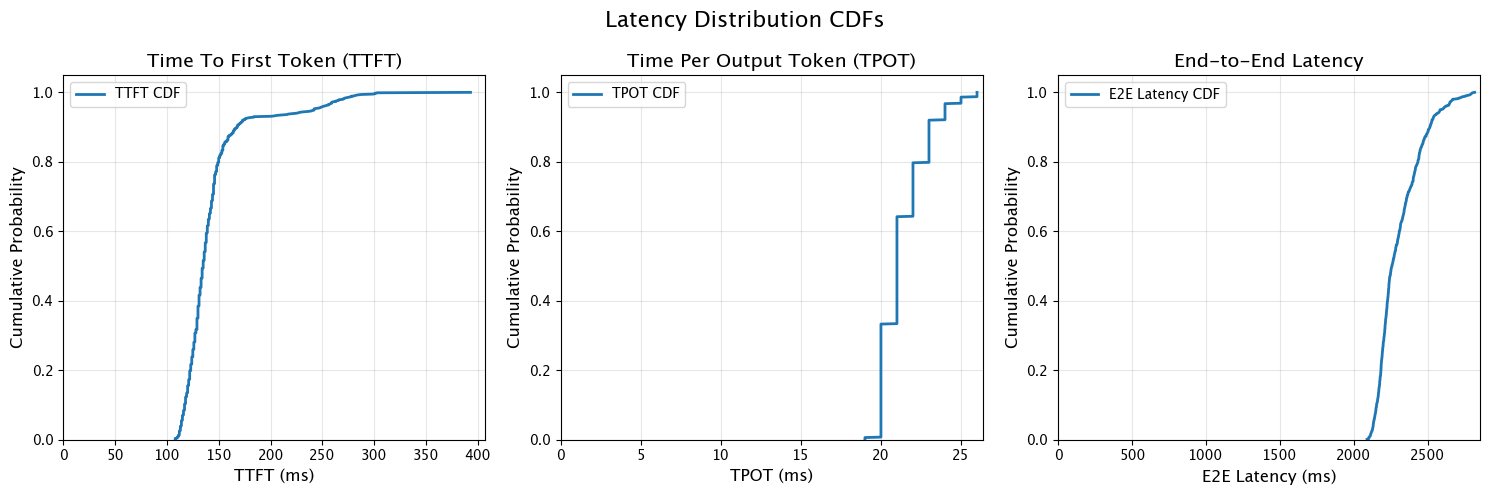

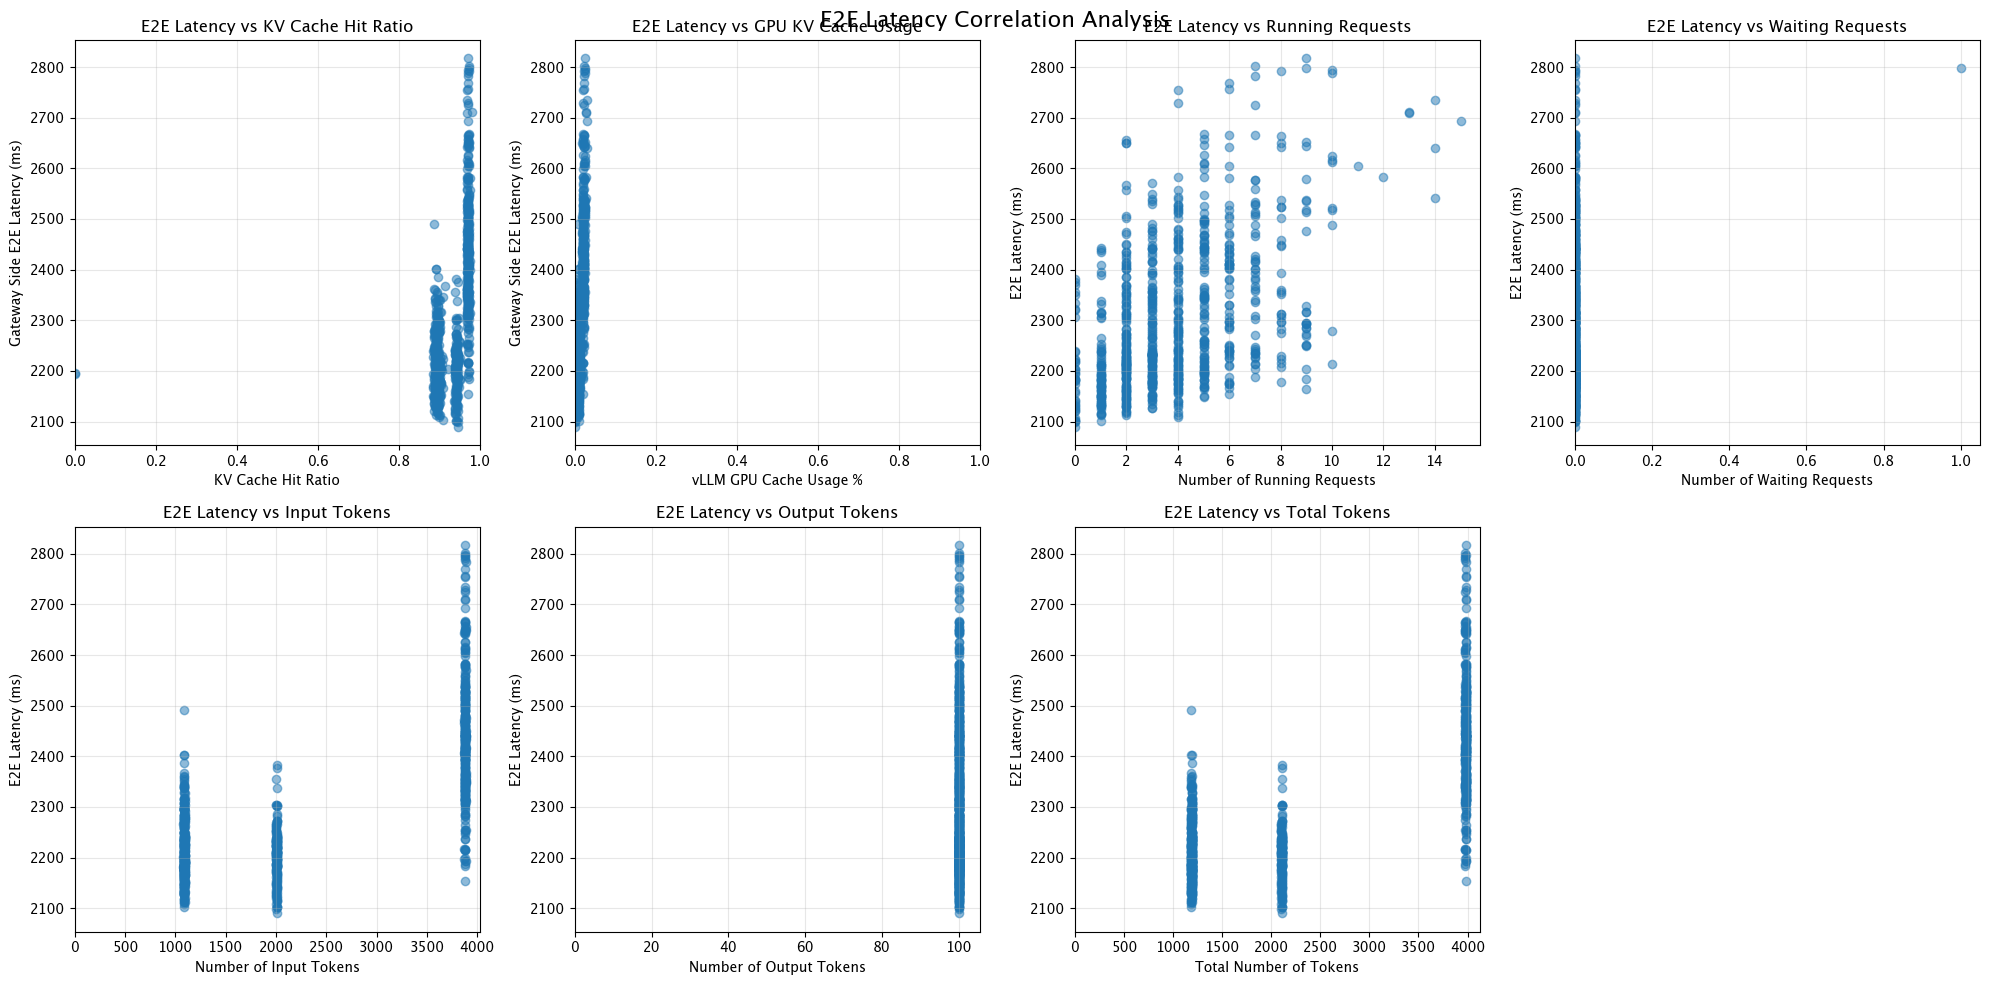

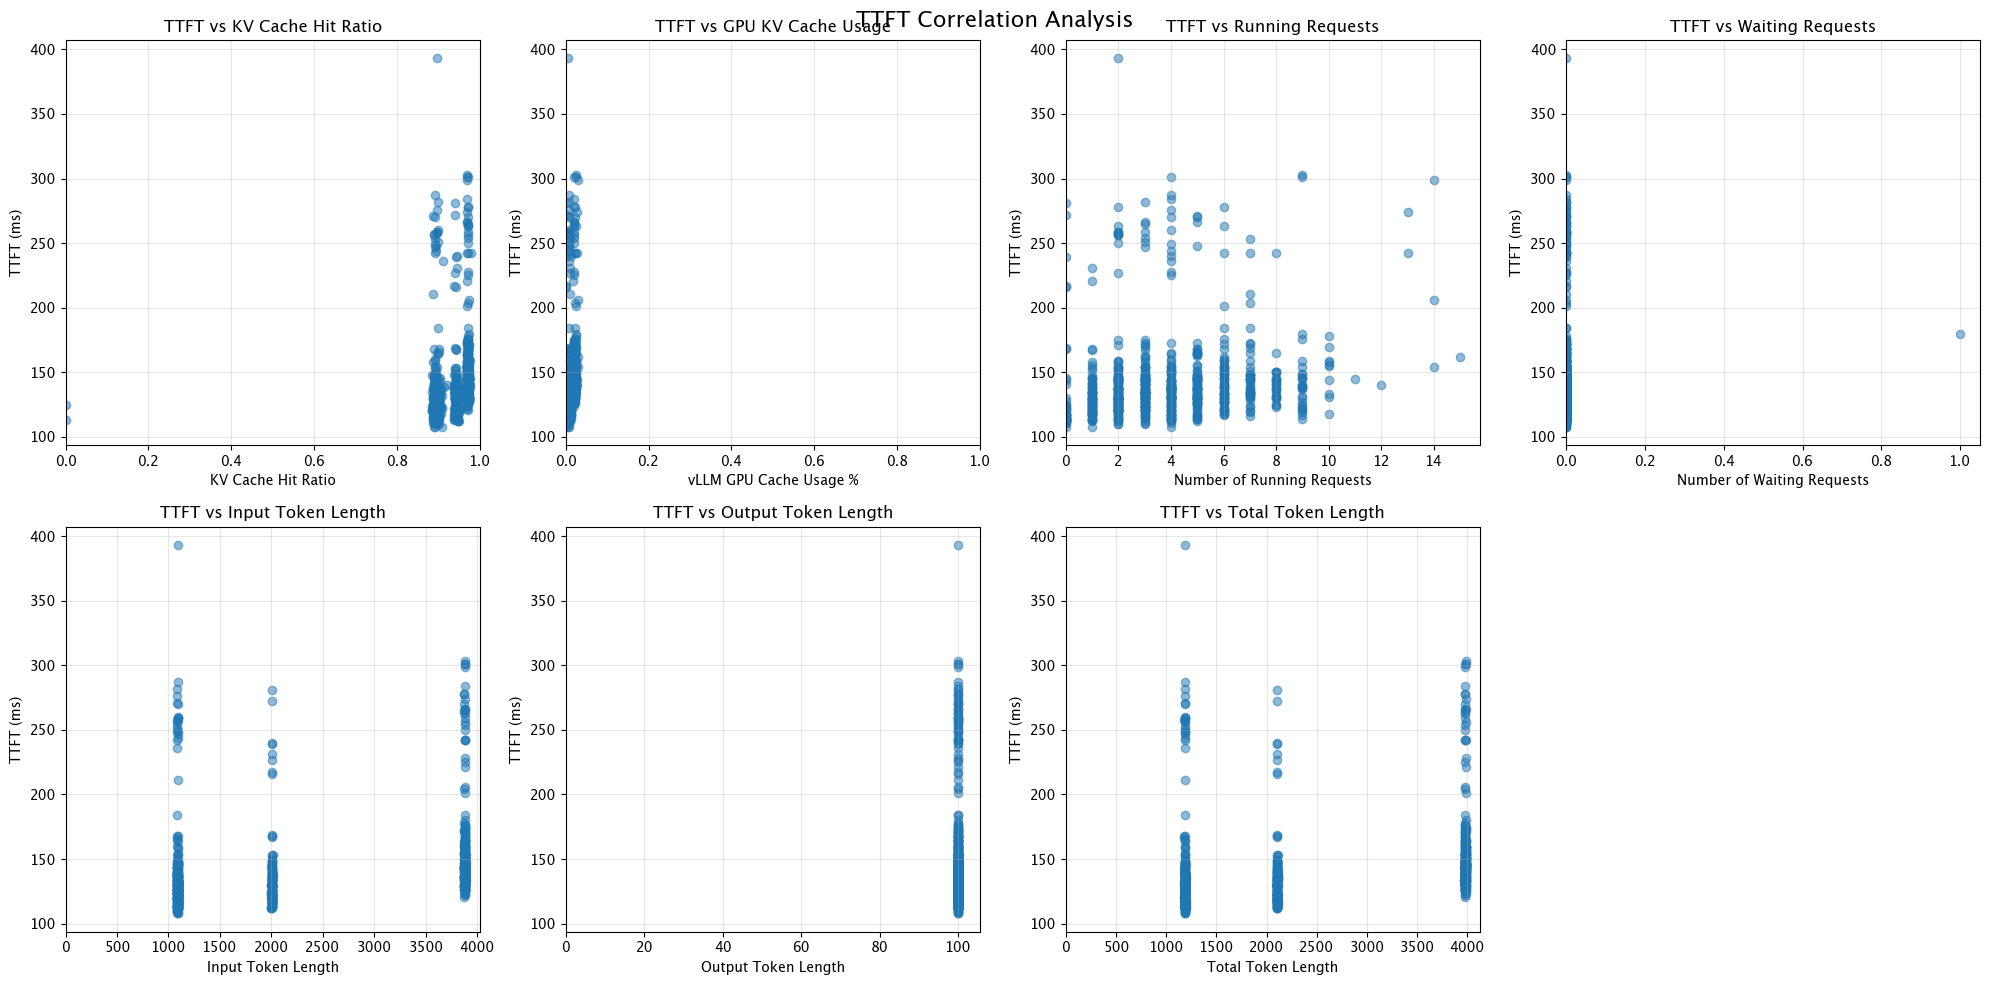

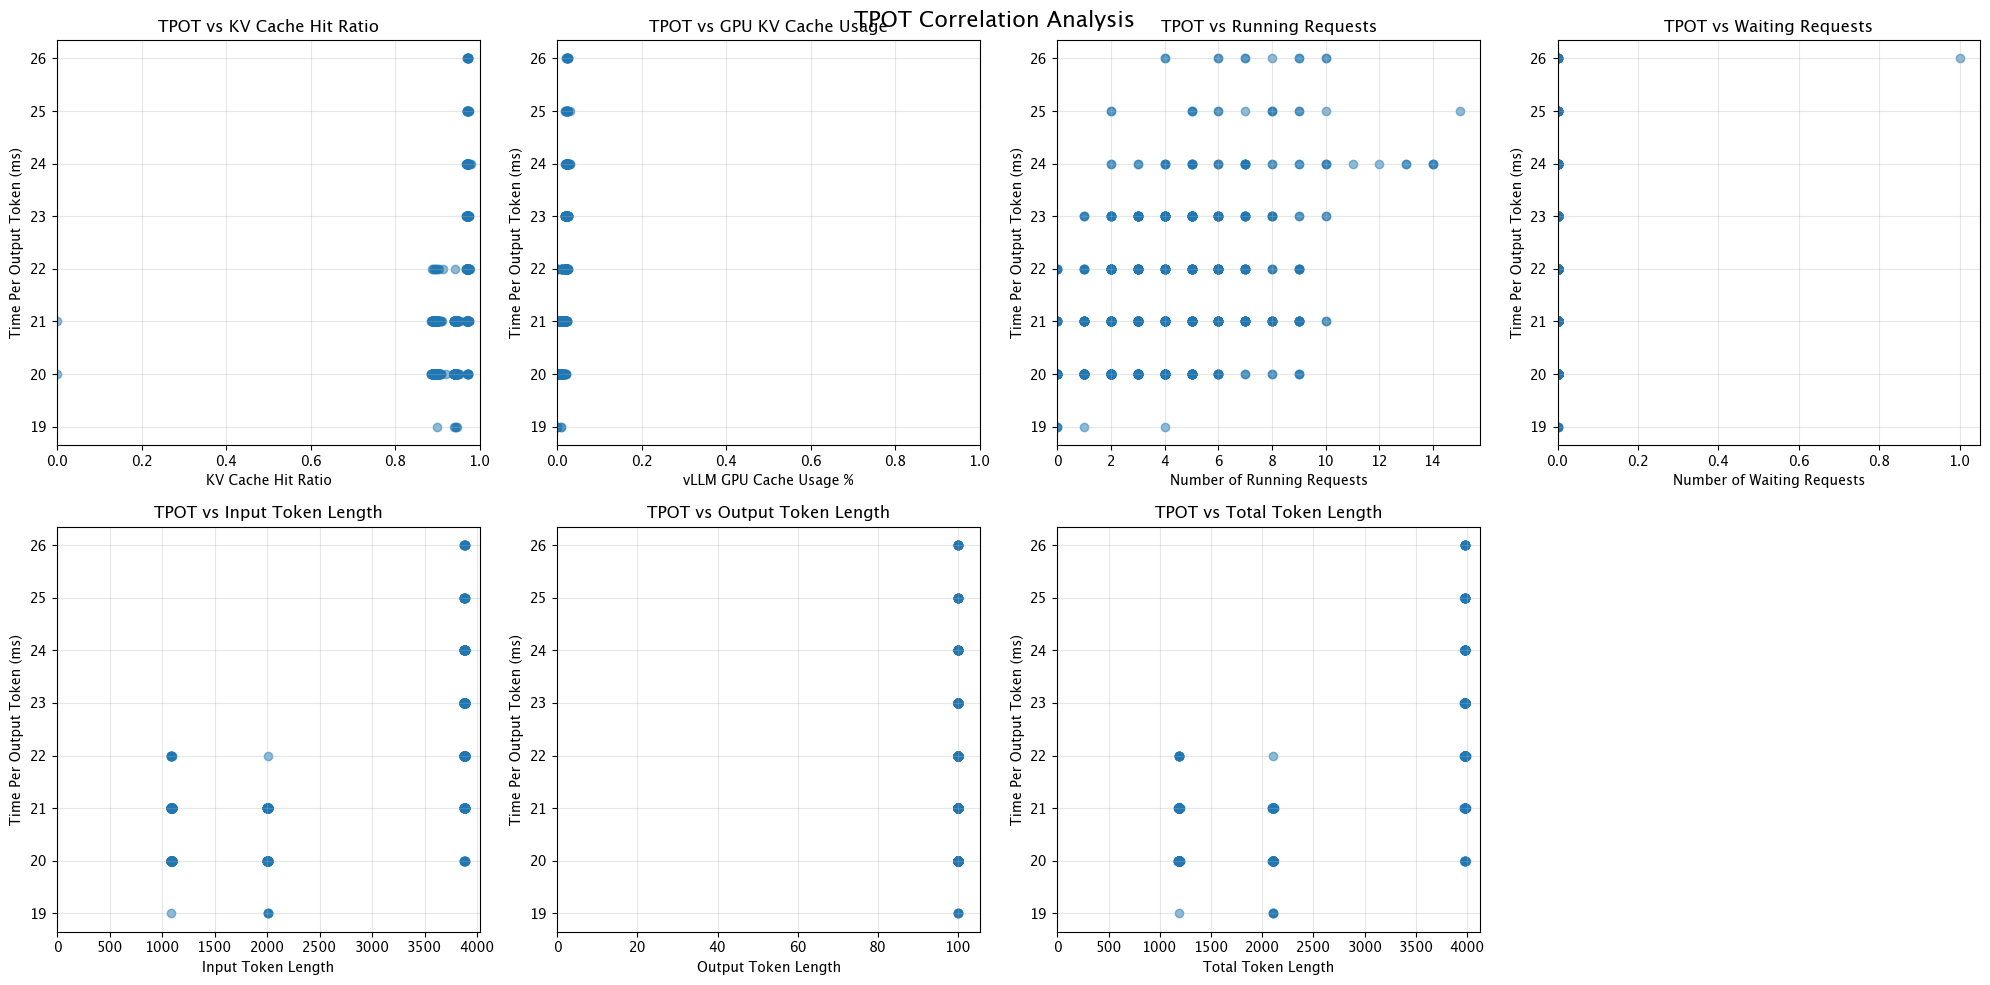

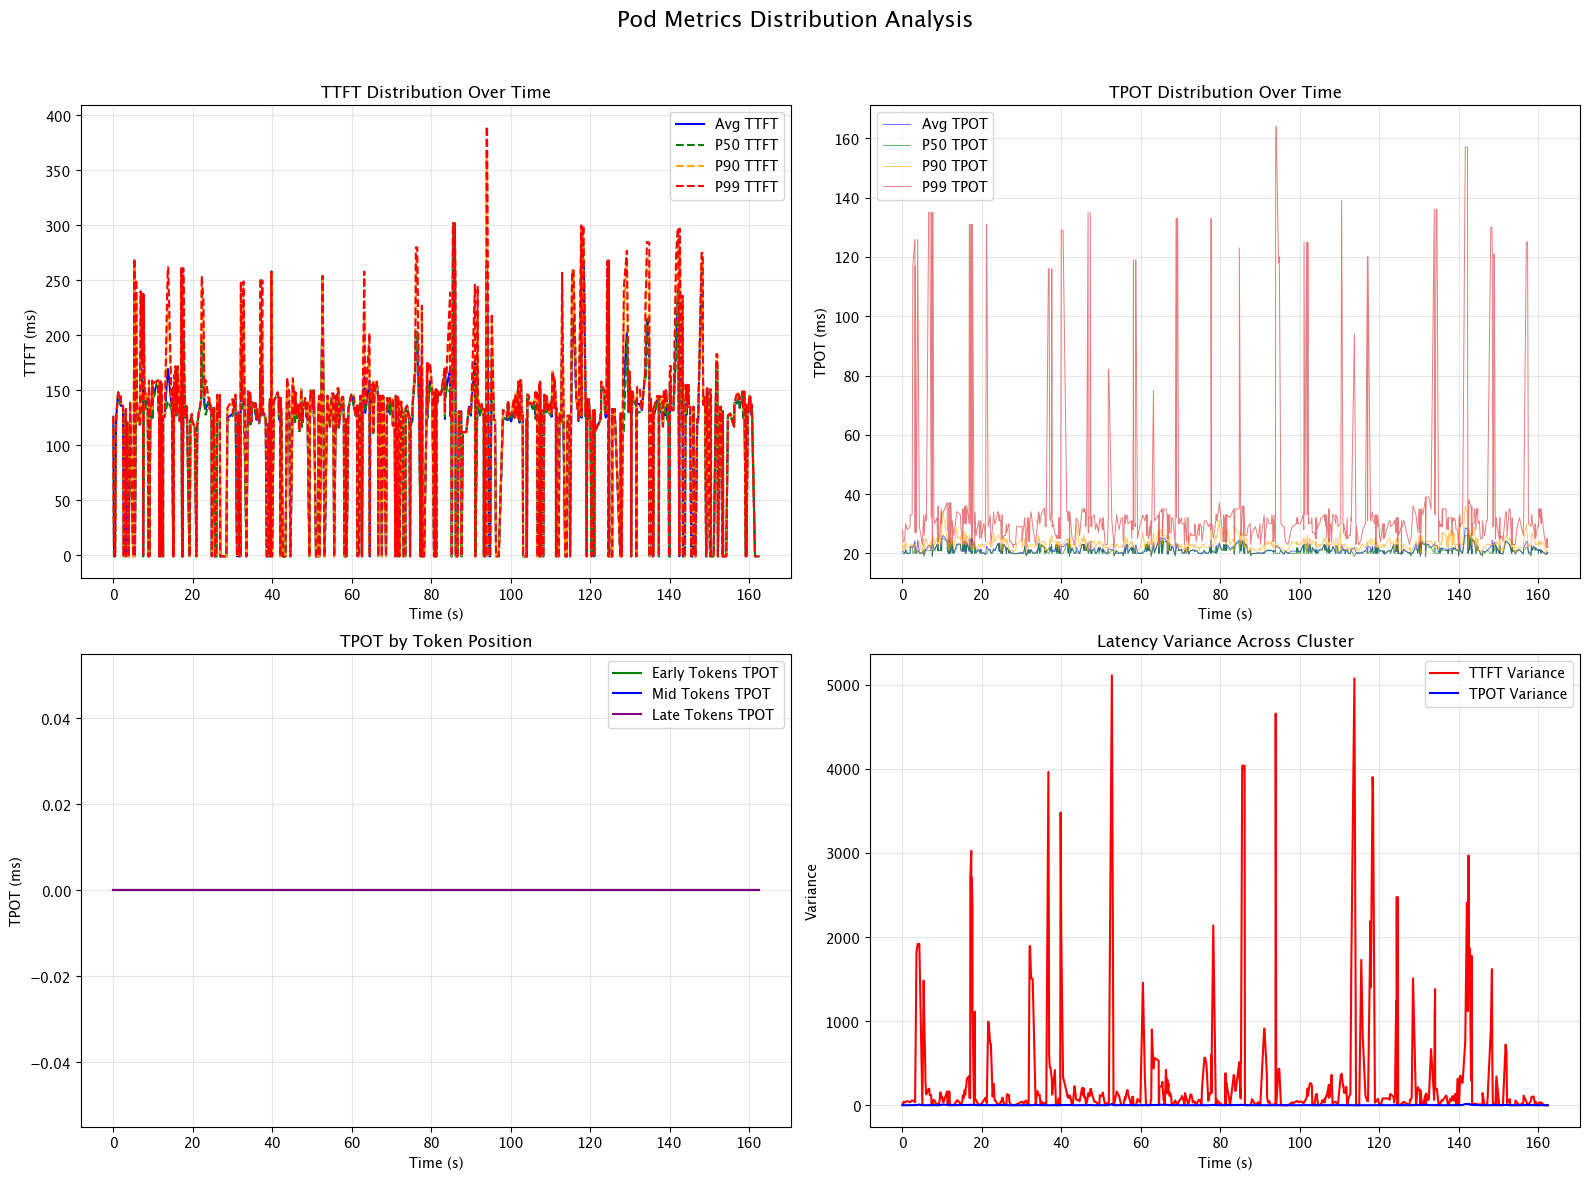

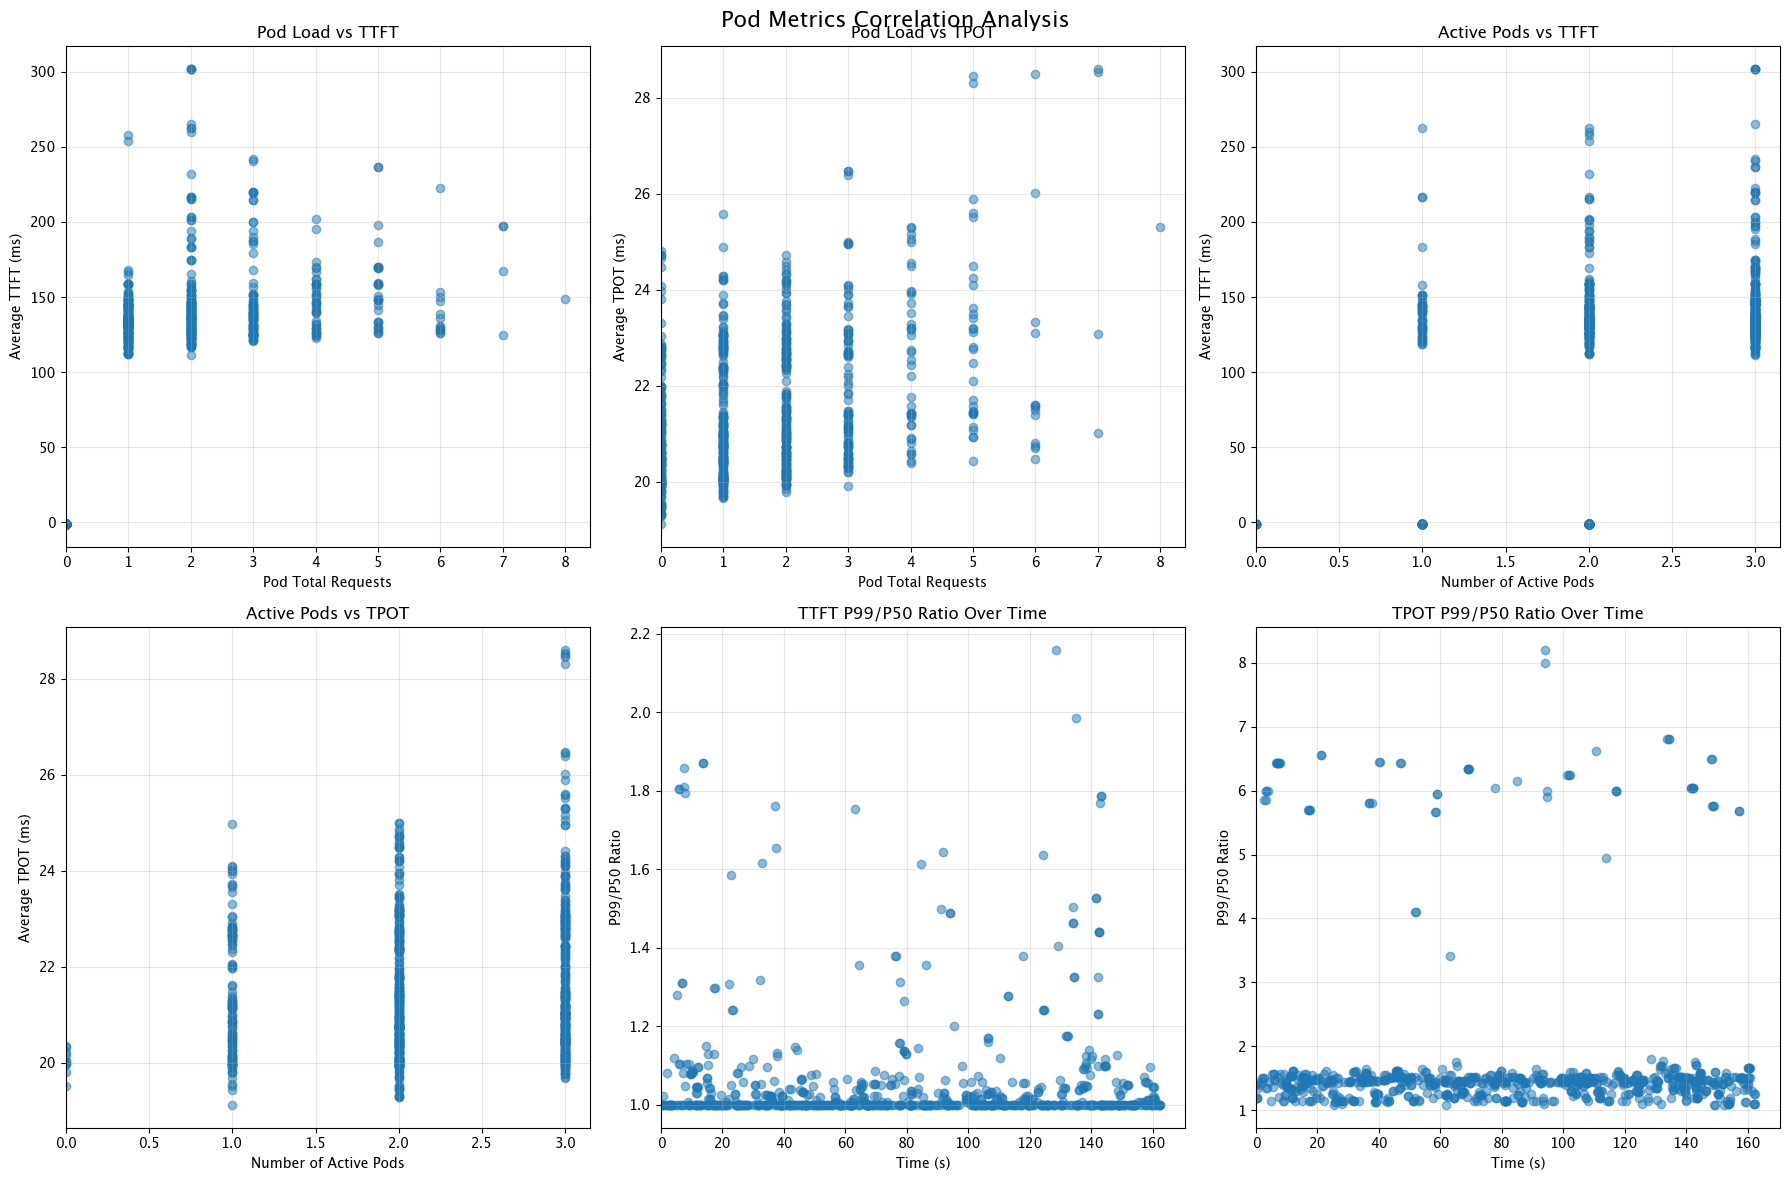

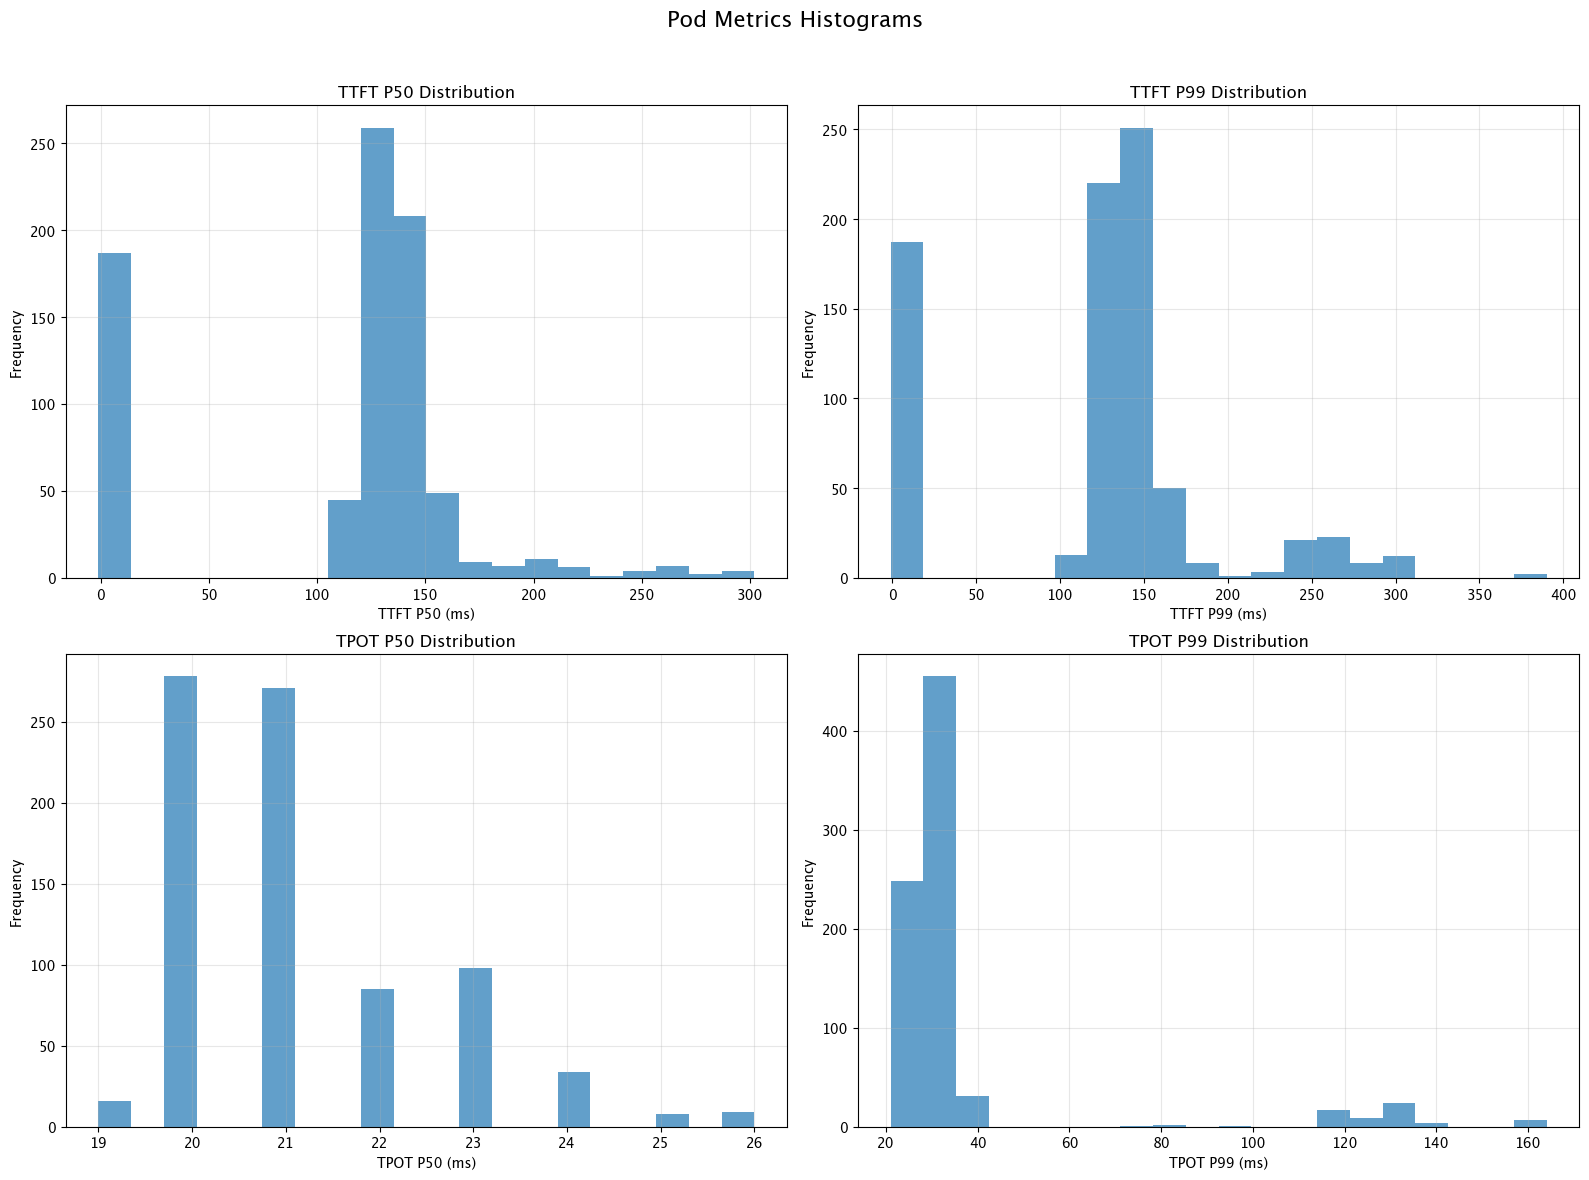

In [8]:
def create_e2e_latency_correlation_plots(df):
    """Create scatter plots for correlations between E2E latency and different metrics as subfigures with 4 per row"""
    
    # Define the correlation plots we want to create
    correlation_plots = []
    
    # Plot 1: E2E latency vs KV Cache Hit Ratio
    if 'gateway_side_e2e_latency' in df.columns and 'selected_pod_kv_cache_hit_ratio' in df.columns:
        correlation_plots.append({
            'x': 'selected_pod_kv_cache_hit_ratio',
            'y': 'gateway_side_e2e_latency',
            'title': 'E2E Latency vs KV Cache Hit Ratio',
            'xlabel': 'KV Cache Hit Ratio',
            'ylabel': 'Gateway Side E2E Latency (ms)',
            'xlim': (0, 1)
        })
    
    # Plot 2: E2E latency vs GPU KV Cache Usage
    if 'gateway_side_e2e_latency' in df.columns and 'selected_pod_vllm_gpu_kv_cache_usage' in df.columns:
        correlation_plots.append({
            'x': 'selected_pod_vllm_gpu_kv_cache_usage',
            'y': 'gateway_side_e2e_latency',
            'title': 'E2E Latency vs GPU KV Cache Usage',
            'xlabel': 'vLLM GPU Cache Usage %',
            'ylabel': 'Gateway Side E2E Latency (ms)',
            'xlim': (0, 1)
        })
    
    # Plot 3: E2E Latency vs Number of Running Requests
    if 'gateway_side_e2e_latency' in df.columns and 'selected_pod_num_running_requests' in df.columns:
        correlation_plots.append({
            'x': 'selected_pod_num_running_requests',
            'y': 'gateway_side_e2e_latency',
            'title': 'E2E Latency vs Running Requests',
            'xlabel': 'Number of Running Requests',
            'ylabel': 'E2E Latency (ms)',
            'xlim': (0, None)
        })
    
    # Plot 4: E2E Latency vs Number of Waiting Requests
    if 'gateway_side_e2e_latency' in df.columns and 'selected_pod_num_waiting_requests' in df.columns:
        correlation_plots.append({
            'x': 'selected_pod_num_waiting_requests',
            'y': 'gateway_side_e2e_latency',
            'title': 'E2E Latency vs Waiting Requests',
            'xlabel': 'Number of Waiting Requests',
            'ylabel': 'E2E Latency (ms)',
            'xlim': (0, None)
        })
    
    # Plot 5: E2E Latency vs Number of Input Tokens
    if 'gateway_side_e2e_latency' in df.columns and 'prompt_tokens' in df.columns:
        correlation_plots.append({
            'x': 'prompt_tokens',
            'y': 'gateway_side_e2e_latency',
            'title': 'E2E Latency vs Input Tokens',
            'xlabel': 'Number of Input Tokens',
            'ylabel': 'E2E Latency (ms)',
            'xlim': (0, None)
        })
    
    # Plot 6: E2E Latency vs Number of Output Tokens
    if 'gateway_side_e2e_latency' in df.columns and 'output_tokens' in df.columns:
        correlation_plots.append({
            'x': 'output_tokens',
            'y': 'gateway_side_e2e_latency',
            'title': 'E2E Latency vs Output Tokens',
            'xlabel': 'Number of Output Tokens',
            'ylabel': 'E2E Latency (ms)',
            'xlim': (0, None)
        })
    
    # Plot 7: E2E Latency vs Total Tokens
    if 'gateway_side_e2e_latency' in df.columns and 'total_tokens' in df.columns:
        correlation_plots.append({
            'x': 'total_tokens',
            'y': 'gateway_side_e2e_latency',
            'title': 'E2E Latency vs Total Tokens',
            'xlabel': 'Total Number of Tokens',
            'ylabel': 'E2E Latency (ms)',
            'xlim': (0, None)
        })
    
    # If no correlation plots are available, return
    if not correlation_plots:
        return
    
    # Calculate number of rows needed (4 plots per row)
    num_plots = len(correlation_plots)
    num_rows = (num_plots + 3) // 4  # Ceiling division
    
    # Create the figure and subplots
    fig, axes = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))
    fig.suptitle('E2E Latency Correlation Analysis', fontsize=16)
    
    # Make axes a 2D array even if it's a 1D array (single row) or a single subplot
    if num_plots == 1:
        axes = np.array([[axes]])
    elif num_rows == 1:
        axes = np.array([axes])
    
    # Create the correlation plots
    for i, plot_config in enumerate(correlation_plots):
        row = i // 4
        col = i % 4
        
        ax = axes[row, col]
        
        x_data = df[plot_config['x']]
        y_data = df[plot_config['y']]
        
        # Add a scatter plot
        ax.scatter(x_data, y_data, alpha=0.5)
        
        # # Add trend line if there are enough points
        # if len(x_data) > 1:
        #     # Calculate trend line
        #     z = np.polyfit(x_data, y_data, 1)
        #     p = np.poly1d(z)
            
        #     # Add trend line to plot
        #     x_trend = np.linspace(min(x_data), max(x_data), 100)
        #     y_trend = p(x_trend)
        #     ax.plot(x_trend, y_trend, 'r--', alpha=0.7)
            
        #     # Add correlation coefficient
        #     corr = np.corrcoef(x_data, y_data)[0, 1]
        #     ax.annotate(f"Correlation: {corr:.2f}", 
        #                 xy=(0.05, 0.95), 
        #                 xycoords='axes fraction',
        #                 backgroundcolor='white',
        #                 alpha=0.8)
        
        ax.set_title(plot_config['title'])
        ax.set_xlabel(plot_config['xlabel'])
        ax.set_ylabel(plot_config['ylabel'])
        
        xlim = plot_config['xlim']
        if xlim[0] is not None:
            if xlim[1] is not None:
                ax.set_xlim(xlim[0], xlim[1])
            else:
                ax.set_xlim(left=xlim[0])
        
        ax.grid(True, alpha=0.3)
    
    # Hide any unused subplots
    for i in range(num_plots, num_rows * 4):
        row = i // 4
        col = i % 4
        fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust for the suptitle
    plt.show()

    
def create_ttft_correlation_plots(df):
    """Create scatter plots for correlations between TTFT and different metrics as subfigures with 4 per row"""
    
    # Define the correlation plots we want to create
    correlation_plots = []
    
    # Plot 1: TTFT vs KV Cache Hit Ratio
    if 'gateway_side_ttft' in df.columns and 'selected_pod_kv_cache_hit_ratio' in df.columns:
        correlation_plots.append({
            'x': 'selected_pod_kv_cache_hit_ratio',
            'y': 'gateway_side_ttft',
            'title': 'TTFT vs KV Cache Hit Ratio',
            'xlabel': 'KV Cache Hit Ratio',
            'ylabel': 'TTFT (ms)',
            'xlim': (0, 1)
        })
    
    # Plot 2: TTFT vs GPU KV Cache Usage
    if 'gateway_side_ttft' in df.columns and 'selected_pod_vllm_gpu_kv_cache_usage' in df.columns:
        correlation_plots.append({
            'x': 'selected_pod_vllm_gpu_kv_cache_usage',
            'y': 'gateway_side_ttft',
            'title': 'TTFT vs GPU KV Cache Usage',
            'xlabel': 'vLLM GPU Cache Usage %',
            'ylabel': 'TTFT (ms)',
            'xlim': (0, 1)
        })
    
    # Plot 3: TTFT vs Number of Running Requests
    if 'gateway_side_ttft' in df.columns and 'selected_pod_num_running_requests' in df.columns:
        correlation_plots.append({
            'x': 'selected_pod_num_running_requests',
            'y': 'gateway_side_ttft',
            'title': 'TTFT vs Running Requests',
            'xlabel': 'Number of Running Requests',
            'ylabel': 'TTFT (ms)',
            'xlim': (0, None)
        })
    
    # Plot 4: TTFT vs Number of Waiting Requests
    if 'gateway_side_ttft' in df.columns and 'selected_pod_num_waiting_requests' in df.columns:
        correlation_plots.append({
            'x': 'selected_pod_num_waiting_requests',
            'y': 'gateway_side_ttft',
            'title': 'TTFT vs Waiting Requests',
            'xlabel': 'Number of Waiting Requests',
            'ylabel': 'TTFT (ms)',
            'xlim': (0, None)
        })
    
    # Plot 5: TTFT vs Input Token Length
    if 'gateway_side_ttft' in df.columns and 'prompt_tokens' in df.columns:
        correlation_plots.append({
            'x': 'prompt_tokens',
            'y': 'gateway_side_ttft',
            'title': 'TTFT vs Input Token Length',
            'xlabel': 'Input Token Length',
            'ylabel': 'TTFT (ms)',
            'xlim': (0, None)
        })
    
    # Plot 6: TTFT vs Output Token Length
    if 'gateway_side_ttft' in df.columns and 'output_tokens' in df.columns:
        correlation_plots.append({
            'x': 'output_tokens',
            'y': 'gateway_side_ttft',
            'title': 'TTFT vs Output Token Length',
            'xlabel': 'Output Token Length',
            'ylabel': 'TTFT (ms)',
            'xlim': (0, None)
        })
    
    # Plot 7: TTFT vs Total Token Length
    if 'gateway_side_ttft' in df.columns and 'total_tokens' in df.columns:
        correlation_plots.append({
            'x': 'total_tokens',
            'y': 'gateway_side_ttft',
            'title': 'TTFT vs Total Token Length',
            'xlabel': 'Total Token Length',
            'ylabel': 'TTFT (ms)',
            'xlim': (0, None)
        })
    
    # If no correlation plots are available, return
    if not correlation_plots:
        return
    
    # Calculate number of rows needed (4 plots per row)
    num_plots = len(correlation_plots)
    num_rows = (num_plots + 3) // 4  # Ceiling division
    
    # Create the figure and subplots
    fig, axes = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))
    fig.suptitle('TTFT Correlation Analysis', fontsize=16)
    
    # Make axes a 2D array even if it's a 1D array (single row) or a single subplot
    if num_plots == 1:
        axes = np.array([[axes]])
    elif num_rows == 1:
        axes = np.array([axes])
    
    # Create the correlation plots
    for i, plot_config in enumerate(correlation_plots):
        row = i // 4
        col = i % 4
        
        ax = axes[row, col]
        
        x_data = df[plot_config['x']]
        y_data = df[plot_config['y']]
        
        # Add a scatter plot
        ax.scatter(x_data, y_data, alpha=0.5)
        
        # # Add trend line if there are enough points
        # if len(x_data) > 1:
        #     # Calculate trend line
        #     z = np.polyfit(x_data, y_data, 1)
        #     p = np.poly1d(z)
            
        #     # Add trend line to plot
        #     x_trend = np.linspace(min(x_data), max(x_data), 100)
        #     y_trend = p(x_trend)
        #     ax.plot(x_trend, y_trend, 'r--', alpha=0.7)
            
        #     # Add correlation coefficient
        #     corr = np.corrcoef(x_data, y_data)[0, 1]
        #     ax.annotate(f"Correlation: {corr:.2f}", 
        #                 xy=(0.05, 0.95), 
        #                 xycoords='axes fraction',
        #                 backgroundcolor='white',
        #                 alpha=0.8)
        
        ax.set_title(plot_config['title'])
        ax.set_xlabel(plot_config['xlabel'])
        ax.set_ylabel(plot_config['ylabel'])
        
        xlim = plot_config['xlim']
        if xlim[0] is not None:
            if xlim[1] is not None:
                ax.set_xlim(xlim[0], xlim[1])
            else:
                ax.set_xlim(left=xlim[0])
        
        ax.grid(True, alpha=0.3)
    
    # Hide any unused subplots
    for i in range(num_plots, num_rows * 4):
        row = i // 4
        col = i % 4
        fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust for the suptitle
    plt.show()


def create_cdf_plots(df):
    """Create Cumulative Distribution Function (CDF) plots for various metrics as subfigures"""
    
    # Check if we have the required columns
    available_plots = []
    if 'gateway_side_ttft' in df.columns:
        available_plots.append('ttft')
    if 'gateway_side_tpot' in df.columns:
        available_plots.append('tpot')
    if 'gateway_side_e2e_latency' in df.columns:
        available_plots.append('e2e')
    
    if not available_plots:
        return
    
    # Create the figure and subplots
    fig, axes = plt.subplots(1, len(available_plots), figsize=(5*len(available_plots), 5))
    fig.suptitle('Latency Distribution CDFs', fontsize=16)
    
    # If only one plot, make axes iterable
    if len(available_plots) == 1:
        axes = [axes]
    
    # Plot index
    plot_idx = 0
    
    # TTFT CDF
    if 'ttft' in available_plots:
        ax = axes[plot_idx]
        ttft = df['gateway_side_ttft'].astype(int)
        ttft_sorted = np.sort(ttft)
        y = np.arange(1, len(ttft_sorted) + 1) / len(ttft_sorted)
        ax.plot(ttft_sorted, y, linewidth=2, label='TTFT CDF')
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('TTFT (ms)', fontsize=12)
        ax.set_ylabel('Cumulative Probability', fontsize=12)
        ax.set_title('Time To First Token (TTFT)', fontsize=14)
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=0)
        ax.legend()
        plot_idx += 1
    
    # TPOT CDF
    if 'tpot' in available_plots:
        ax = axes[plot_idx]
        tpot = df['gateway_side_tpot'].astype(int)
        tpot_sorted = np.sort(tpot)
        y = np.arange(1, len(tpot_sorted) + 1) / len(tpot_sorted)
        ax.plot(tpot_sorted, y, linewidth=2, label='TPOT CDF')
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('TPOT (ms)', fontsize=12)
        ax.set_ylabel('Cumulative Probability', fontsize=12)
        ax.set_title('Time Per Output Token (TPOT)', fontsize=14)
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=0)
        ax.legend()
        plot_idx += 1
    
    # E2E Latency CDF
    if 'e2e' in available_plots:
        ax = axes[plot_idx]
        e2e_latency = df['gateway_side_e2e_latency'].astype(int)
        e2e_latency_sorted = np.sort(e2e_latency)
        y = np.arange(1, len(e2e_latency_sorted) + 1) / len(e2e_latency_sorted)
        ax.plot(e2e_latency_sorted, y, linewidth=2, label='E2E Latency CDF')
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('E2E Latency (ms)', fontsize=12)
        ax.set_ylabel('Cumulative Probability', fontsize=12)
        ax.set_title('End-to-End Latency', fontsize=14)
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=0)
        ax.legend()
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust for the suptitle



def create_cdf_plots(df):
    """Create Cumulative Distribution Function (CDF) plots for various metrics as subfigures"""
    
    # Check if we have the required columns
    available_plots = []
    if 'gateway_side_ttft' in df.columns:
        available_plots.append('ttft')
    if 'gateway_side_tpot' in df.columns:
        available_plots.append('tpot')
    if 'gateway_side_e2e_latency' in df.columns:
        available_plots.append('e2e')
    
    if not available_plots:
        return
    
    # Create the figure and subplots
    fig, axes = plt.subplots(1, len(available_plots), figsize=(5*len(available_plots), 5))
    fig.suptitle('Latency Distribution CDFs', fontsize=16)
    
    # If only one plot, make axes iterable
    if len(available_plots) == 1:
        axes = [axes]
    
    # Plot index
    plot_idx = 0
    
    # TTFT CDF
    if 'ttft' in available_plots:
        ax = axes[plot_idx]
        ttft = df['gateway_side_ttft'].astype(int)
        ttft_sorted = np.sort(ttft)
        y = np.arange(1, len(ttft_sorted) + 1) / len(ttft_sorted)
        ax.plot(ttft_sorted, y, linewidth=2, label='TTFT CDF')
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('TTFT (ms)', fontsize=12)
        ax.set_ylabel('Cumulative Probability', fontsize=12)
        ax.set_title('Time To First Token (TTFT)', fontsize=14)
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=0)
        ax.legend()
        plot_idx += 1
    
    # TPOT CDF
    if 'tpot' in available_plots:
        ax = axes[plot_idx]
        tpot = df['gateway_side_tpot'].astype(int)
        tpot_sorted = np.sort(tpot)
        y = np.arange(1, len(tpot_sorted) + 1) / len(tpot_sorted)
        ax.plot(tpot_sorted, y, linewidth=2, label='TPOT CDF')
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('TPOT (ms)', fontsize=12)
        ax.set_ylabel('Cumulative Probability', fontsize=12)
        ax.set_title('Time Per Output Token (TPOT)', fontsize=14)
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=0)
        ax.legend()
        plot_idx += 1
    
    # E2E Latency CDF
    if 'e2e' in available_plots:
        ax = axes[plot_idx]
        e2e_latency = df['gateway_side_e2e_latency'].astype(int)
        e2e_latency_sorted = np.sort(e2e_latency)
        y = np.arange(1, len(e2e_latency_sorted) + 1) / len(e2e_latency_sorted)
        ax.plot(e2e_latency_sorted, y, linewidth=2, label='E2E Latency CDF')
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('E2E Latency (ms)', fontsize=12)
        ax.set_ylabel('Cumulative Probability', fontsize=12)
        ax.set_title('End-to-End Latency', fontsize=14)
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=0)
        ax.legend()
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust for the suptitle


def create_tpot_correlation_plots(df):
    """Create scatter plots for correlations between TPOT and different metrics as subfigures with 4 per row"""
    
    # Define the correlation plots we want to create
    correlation_plots = []
    
    # Plot 1: TPOT vs KV Cache Hit Ratio
    if 'gateway_side_tpot' in df.columns and 'selected_pod_kv_cache_hit_ratio' in df.columns:
        correlation_plots.append({
            'x': 'selected_pod_kv_cache_hit_ratio',
            'y': 'gateway_side_tpot',
            'title': 'TPOT vs KV Cache Hit Ratio',
            'xlabel': 'KV Cache Hit Ratio',
            'ylabel': 'Time Per Output Token (ms)',
            'xlim': (0, 1)
        })
    
    # Plot 2: TPOT vs GPU KV Cache Usage
    if 'gateway_side_tpot' in df.columns and 'selected_pod_vllm_gpu_kv_cache_usage' in df.columns:
        correlation_plots.append({
            'x': 'selected_pod_vllm_gpu_kv_cache_usage',
            'y': 'gateway_side_tpot',
            'title': 'TPOT vs GPU KV Cache Usage',
            'xlabel': 'vLLM GPU Cache Usage %',
            'ylabel': 'Time Per Output Token (ms)',
            'xlim': (0, 1)
        })
    
    # Plot 3: TPOT vs Number of Running Requests
    if 'gateway_side_tpot' in df.columns and 'selected_pod_num_running_requests' in df.columns:
        correlation_plots.append({
            'x': 'selected_pod_num_running_requests',
            'y': 'gateway_side_tpot',
            'title': 'TPOT vs Running Requests',
            'xlabel': 'Number of Running Requests',
            'ylabel': 'Time Per Output Token (ms)',
            'xlim': (0, None)
        })
    
    # Plot 4: TPOT vs Number of Waiting Requests
    if 'gateway_side_tpot' in df.columns and 'selected_pod_num_waiting_requests' in df.columns:
        correlation_plots.append({
            'x': 'selected_pod_num_waiting_requests',
            'y': 'gateway_side_tpot',
            'title': 'TPOT vs Waiting Requests',
            'xlabel': 'Number of Waiting Requests',
            'ylabel': 'Time Per Output Token (ms)',
            'xlim': (0, None)
        })
    
    # Plot 5: TPOT vs Input Token Length
    if 'gateway_side_tpot' in df.columns and 'prompt_tokens' in df.columns:
        correlation_plots.append({
            'x': 'prompt_tokens',
            'y': 'gateway_side_tpot',
            'title': 'TPOT vs Input Token Length',
            'xlabel': 'Input Token Length',
            'ylabel': 'Time Per Output Token (ms)',
            'xlim': (0, None)
        })
    
    # Plot 6: TPOT vs Output Token Length
    if 'gateway_side_tpot' in df.columns and 'output_tokens' in df.columns:
        correlation_plots.append({
            'x': 'output_tokens',
            'y': 'gateway_side_tpot',
            'title': 'TPOT vs Output Token Length',
            'xlabel': 'Output Token Length',
            'ylabel': 'Time Per Output Token (ms)',
            'xlim': (0, None)
        })
    
    # Plot 7: TPOT vs Total Token Length
    if 'gateway_side_tpot' in df.columns and 'total_tokens' in df.columns:
        correlation_plots.append({
            'x': 'total_tokens',
            'y': 'gateway_side_tpot',
            'title': 'TPOT vs Total Token Length',
            'xlabel': 'Total Token Length',
            'ylabel': 'Time Per Output Token (ms)',
            'xlim': (0, None)
        })
    
    # If no correlation plots are available, return
    if not correlation_plots:
        return
    
    # Calculate number of rows needed (4 plots per row)
    num_plots = len(correlation_plots)
    num_rows = (num_plots + 3) // 4  # Ceiling division
    
    # Create the figure and subplots
    fig, axes = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))
    fig.suptitle('TPOT Correlation Analysis', fontsize=16)
    
    # Make axes a 2D array even if it's a 1D array (single row) or a single subplot
    if num_plots == 1:
        axes = np.array([[axes]])
    elif num_rows == 1:
        axes = np.array([axes])
    
    # Create the correlation plots
    for i, plot_config in enumerate(correlation_plots):
        row = i // 4
        col = i % 4
        
        ax = axes[row, col]
        
        x_data = df[plot_config['x']]
        y_data = df[plot_config['y']]
        
        # Add a scatter plot with a trend line
        ax.scatter(x_data, y_data, alpha=0.5)
        
        # # Add trend line if there are enough points
        # if len(x_data) > 1:
        #     # Calculate trend line
        #     z = np.polyfit(x_data, y_data, 1)
        #     p = np.poly1d(z)
            
        #     # Add trend line to plot
        #     x_trend = np.linspace(min(x_data), max(x_data), 100)
        #     y_trend = p(x_trend)
        #     ax.plot(x_trend, y_trend, 'r--', alpha=0.7)
            
        #     # Add correlation coefficient
        #     corr = np.corrcoef(x_data, y_data)[0, 1]
        #     ax.annotate(f"Correlation: {corr:.2f}", 
        #                 xy=(0.05, 0.95), 
        #                 xycoords='axes fraction',
        #                 backgroundcolor='white',
        #                 alpha=0.8)
        
        ax.set_title(plot_config['title'])
        ax.set_xlabel(plot_config['xlabel'])
        ax.set_ylabel(plot_config['ylabel'])
        
        xlim = plot_config['xlim']
        if xlim[0] is not None:
            if xlim[1] is not None:
                ax.set_xlim(xlim[0], xlim[1])
            else:
                ax.set_xlim(left=xlim[0])
        
        ax.grid(True, alpha=0.3)
    
    # Hide any unused subplots
    for i in range(num_plots, num_rows * 4):
        row = i // 4
        col = i % 4
        fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust for the suptitle
    plt.show()


def create_pod_metrics_distribution_plots(df):
    """Create plots showing the distribution of metrics across pods"""
    
    # Check if we have pod metrics data
    if 'podMetricsLastSecond' not in df.columns:
        print("No pod metrics data available for plotting")
        return
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Pod Metrics Distribution Analysis', fontsize=16)
    
    # Plot 1: TTFT distribution over time with percentiles
    ax = axes[0, 0]
    ax.plot(df['normalized_start_time'], df['selected_pod_avg_ttft_ms'], label='Avg TTFT', color='blue')
    ax.plot(df['normalized_start_time'], df['selected_pod_p50_ttft_ms'], label='P50 TTFT', color='green', linestyle='--')
    ax.plot(df['normalized_start_time'], df['selected_pod_p90_ttft_ms'], label='P90 TTFT', color='orange', linestyle='--')
    ax.plot(df['normalized_start_time'], df['selected_pod_p99_ttft_ms'], label='P99 TTFT', color='red', linestyle='--')
    ax.set_title('TTFT Distribution Over Time')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('TTFT (ms)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Plot 2: TPOT distribution over time with percentiles
    ax = axes[0, 1]
    ax.plot(df['normalized_start_time'], df['selected_pod_avg_tpot_ms'], label=f'Avg TPOT', color='blue', linewidth=0.7, alpha=0.6)
    ax.plot(df['normalized_start_time'], df['selected_pod_p50_tpot_ms'], label='P50 TPOT', color='green', linewidth=0.7, alpha=0.6)
    ax.plot(df['normalized_start_time'], df['selected_pod_p90_tpot_ms'], label='P90 TPOT', color='orange', linewidth=0.7, alpha=0.6)
    ax.plot(df['normalized_start_time'], df['selected_pod_p99_tpot_ms'], label='P99 TPOT', color='tab:red', linewidth=0.7, alpha=0.6)
    ax.set_title('TPOT Distribution Over Time')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('TPOT (ms)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Plot 3: TPOT by token position (early, mid, late)
    ax = axes[1, 0]
    ax.plot(df['normalized_start_time'], df['selected_pod_early_tokens_tpot_ms'], label='Early Tokens TPOT', color='green')
    ax.plot(df['normalized_start_time'], df['selected_pod_mid_tokens_tpot_ms'], label='Mid Tokens TPOT', color='blue')
    ax.plot(df['normalized_start_time'], df['selected_pod_late_tokens_tpot_ms'], label='Late Tokens TPOT', color='purple')
    ax.set_title('TPOT by Token Position')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('TPOT (ms)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Plot 4: Variance across cluster
    ax = axes[1, 1]
    ax.plot(df['normalized_start_time'], df['ttft_variance_across_cluster'], label='TTFT Variance', color='red')
    ax.plot(df['normalized_start_time'], df['tpot_variance_across_cluster'], label='TPOT Variance', color='blue')
    ax.set_title('Latency Variance Across Cluster')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Variance')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


def create_pod_metrics_correlation_plots(df):
    """Create correlation plots for pod metrics"""
    
    # Define the correlation plots we want to create
    correlation_plots = []
    
    # Plot 1: Pod Load vs TTFT
    if 'selected_pod_total_requests' in df.columns and 'selected_pod_avg_ttft_ms' in df.columns:
        correlation_plots.append({
            'x': 'selected_pod_total_requests',
            'y': 'selected_pod_avg_ttft_ms',
            'title': 'Pod Load vs TTFT',
            'xlabel': 'Pod Total Requests',
            'ylabel': 'Average TTFT (ms)',
            'xlim': (0, None)
        })
    
    # Plot 2: Pod Load vs TPOT
    if 'selected_pod_total_requests' in df.columns and 'selected_pod_avg_tpot_ms' in df.columns:
        correlation_plots.append({
            'x': 'selected_pod_total_requests',
            'y': 'selected_pod_avg_tpot_ms',
            'title': 'Pod Load vs TPOT',
            'xlabel': 'Pod Total Requests',
            'ylabel': 'Average TPOT (ms)',
            'xlim': (0, None)
        })
    
    # Plot 3: Active Pods Count vs TTFT
    if 'active_pods_count' in df.columns and 'selected_pod_avg_ttft_ms' in df.columns:
        correlation_plots.append({
            'x': 'active_pods_count',
            'y': 'selected_pod_avg_ttft_ms',
            'title': 'Active Pods vs TTFT',
            'xlabel': 'Number of Active Pods',
            'ylabel': 'Average TTFT (ms)',
            'xlim': (0, None)
        })
    
    # Plot 4: Active Pods Count vs TPOT
    if 'active_pods_count' in df.columns and 'selected_pod_avg_tpot_ms' in df.columns:
        correlation_plots.append({
            'x': 'active_pods_count',
            'y': 'selected_pod_avg_tpot_ms',
            'title': 'Active Pods vs TPOT',
            'xlabel': 'Number of Active Pods',
            'ylabel': 'Average TPOT (ms)',
            'xlim': (0, None)
        })
    
    # Plot 5: TTFT P99/P50 Ratio Over Time
    df['ttft_p99_p50_ratio'] = df['selected_pod_p99_ttft_ms'] / df['selected_pod_p50_ttft_ms']
    correlation_plots.append({
        'x': 'normalized_start_time',
        'y': 'ttft_p99_p50_ratio',
        'title': 'TTFT P99/P50 Ratio Over Time',
        'xlabel': 'Time (s)',
        'ylabel': 'P99/P50 Ratio',
        'xlim': (0, None)
    })
    
    # Plot 6: TPOT P99/P50 Ratio Over Time
    df['tpot_p99_p50_ratio'] = df['selected_pod_p99_tpot_ms'] / df['selected_pod_p50_tpot_ms']
    correlation_plots.append({
        'x': 'normalized_start_time',
        'y': 'tpot_p99_p50_ratio',
        'title': 'TPOT P99/P50 Ratio Over Time',
        'xlabel': 'Time (s)',
        'ylabel': 'P99/P50 Ratio',
        'xlim': (0, None)
    })
    
    # If no correlation plots are available, return
    if not correlation_plots:
        return
    
    # Calculate number of rows needed (3 plots per row)
    num_plots = len(correlation_plots)
    num_rows = (num_plots + 2) // 3  # Ceiling division
    
    # Create the figure and subplots
    fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6 * num_rows))
    fig.suptitle('Pod Metrics Correlation Analysis', fontsize=16)
    
    # Make axes a 2D array even if it's a 1D array (single row) or a single subplot
    if num_plots == 1:
        axes = np.array([[axes]])
    elif num_rows == 1:
        axes = np.array([axes])
    
    # Create the correlation plots
    for i, plot_config in enumerate(correlation_plots):
        row = i // 3
        col = i % 3
        
        ax = axes[row, col]
        
        x_data = df[plot_config['x']]
        y_data = df[plot_config['y']]
        
        # Add a scatter plot
        ax.scatter(x_data, y_data, alpha=0.5)
        
        # # Add trend line if there are enough points
        # if len(x_data) > 1:
        #     # Calculate trend line
        #     z = np.polyfit(x_data, y_data, 1)
        #     p = np.poly1d(z)
            
        #     # Add trend line to plot
        #     x_trend = np.linspace(min(x_data), max(x_data), 100)
        #     y_trend = p(x_trend)
        #     ax.plot(x_trend, y_trend, 'r--', alpha=0.7)
            
        #     # Add correlation coefficient
        #     corr = np.corrcoef(x_data, y_data)[0, 1]
        #     ax.annotate(f"Correlation: {corr:.2f}", 
        #                 xy=(0.05, 0.95), 
        #                 xycoords='axes fraction',
        #                 backgroundcolor='white',
        #                 alpha=0.8)
        
        ax.set_title(plot_config['title'])
        ax.set_xlabel(plot_config['xlabel'])
        ax.set_ylabel(plot_config['ylabel'])
        
        xlim = plot_config['xlim']
        if xlim[0] is not None:
            if xlim[1] is not None:
                ax.set_xlim(xlim[0], xlim[1])
            else:
                ax.set_xlim(left=xlim[0])
        
        ax.grid(True, alpha=0.3)
    
    # Hide any unused subplots
    for i in range(num_plots, num_rows * 3):
        row = i // 3
        col = i % 3
        fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust for the suptitle
    plt.show()


def create_pod_metrics_histograms(df):
    """Create histograms for pod metrics distributions"""
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Pod Metrics Histograms', fontsize=16)
    
    # Plot 1: TTFT P50 histogram
    ax = axes[0, 0]
    ax.hist(df['selected_pod_p50_ttft_ms'].dropna(), bins=20, alpha=0.7)
    ax.set_title('TTFT P50 Distribution')
    ax.set_xlabel('TTFT P50 (ms)')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)
    
    # Plot 2: TTFT P99 histogram
    ax = axes[0, 1]
    ax.hist(df['selected_pod_p99_ttft_ms'].dropna(), bins=20, alpha=0.7)
    ax.set_title('TTFT P99 Distribution')
    ax.set_xlabel('TTFT P99 (ms)')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)
    
    # Plot 3: TPOT P50 histogram
    ax = axes[1, 0]
    ax.hist(df['selected_pod_p50_tpot_ms'].dropna(), bins=20, alpha=0.7)
    ax.set_title('TPOT P50 Distribution')
    ax.set_xlabel('TPOT P50 (ms)')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)
    
    # Plot 4: TPOT P99 histogram
    ax = axes[1, 1]
    ax.hist(df['selected_pod_p99_tpot_ms'].dropna(), bins=20, alpha=0.7)
    ax.set_title('TPOT P99 Distribution')
    ax.set_xlabel('TPOT P99 (ms)')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

create_cdf_plots(df)
create_e2e_latency_correlation_plots(df)
create_ttft_correlation_plots(df)
create_tpot_correlation_plots(df)

create_pod_metrics_distribution_plots(df)
create_pod_metrics_correlation_plots(df)
create_pod_metrics_histograms(df)

Starting comprehensive latency analysis...
CORRELATIONS WITH LATENCY METRICS

gateway_side_ttft correlations:
selected_pod_vllm_gpu_kv_cache_usage: 0.260
prompt_tokens: 0.235
total_tokens: 0.235
selected_pod_num_running_requests: 0.161
selected_pod_kv_cache_hit_ratio: 0.148
total_num_inflight_requests: 0.061
selected_pod_num_waiting_requests: 0.037
output_tokens: nan

gateway_side_tpot correlations:
selected_pod_vllm_gpu_kv_cache_usage: 0.775
prompt_tokens: 0.740
total_tokens: 0.740
selected_pod_num_running_requests: 0.472
selected_pod_kv_cache_hit_ratio: 0.417
total_num_inflight_requests: 0.221
selected_pod_num_waiting_requests: 0.118
output_tokens: nan

gateway_side_e2e_latency correlations:
selected_pod_vllm_gpu_kv_cache_usage: 0.785
prompt_tokens: 0.737
total_tokens: 0.737
selected_pod_num_running_requests: 0.493
selected_pod_kv_cache_hit_ratio: 0.416
total_num_inflight_requests: 0.216
selected_pod_num_waiting_requests: 0.119
output_tokens: nan

THRESHOLD ANALYSIS

gateway_side_ttf

/var/folders/3p/79mj7jcd2gl00sm3dwn578080000gn/T/ipykernel_82296/1190551669.py:465: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
/Users/bytedance/myenv/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)



gateway_side_ttft regression coefficients (higher = more impact):
selected_pod_num_running_requests: 4.214
total_tokens: 2.561
prompt_tokens: 2.561
selected_pod_vllm_gpu_kv_cache_usage: 2.381
total_num_inflight_requests: -1.361
selected_pod_kv_cache_hit_ratio: 0.827
selected_pod_num_waiting_requests: 0.706
output_tokens: 0.000
R² score: 0.073

gateway_side_tpot regression coefficients (higher = more impact):
selected_pod_num_running_requests: 0.545
total_tokens: 0.483
prompt_tokens: 0.483
selected_pod_num_waiting_requests: 0.089
total_num_inflight_requests: -0.044
selected_pod_vllm_gpu_kv_cache_usage: -0.031
selected_pod_kv_cache_hit_ratio: 0.015
output_tokens: 0.000
R² score: 0.684

gateway_side_e2e_latency regression coefficients (higher = more impact):
selected_pod_num_running_requests: 61.089
total_tokens: 48.353
prompt_tokens: 48.353
selected_pod_num_waiting_requests: 9.446
total_num_inflight_requests: -8.683
selected_pod_kv_cache_hit_ratio: 1.966
selected_pod_vllm_gpu_kv_cache_u

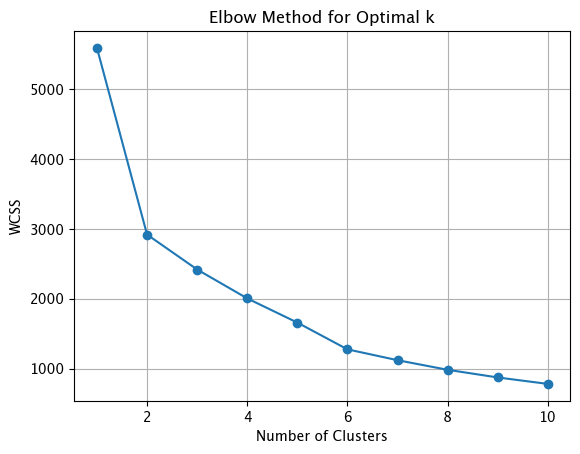

CLUSTER ANALYSIS WITH 3 CLUSTERS

Cluster centers:
         gateway_side_ttft  gateway_side_tpot  gateway_side_e2e_latency  \
cluster                                                                   
0               155.455446          22.759076               2454.306931   
1               136.212551          20.485830               2214.615385   
2               119.000000          20.500000               2194.000000   

         selected_pod_kv_cache_hit_ratio  \
cluster                                    
0                               0.971082   
1                               0.912648   
2                               0.000000   

         selected_pod_vllm_gpu_kv_cache_usage  \
cluster                                         
0                                    0.021253   
1                                    0.008210   
2                                    0.000000   

         selected_pod_num_running_requests  prompt_tokens  output_tokens  
cluster                        

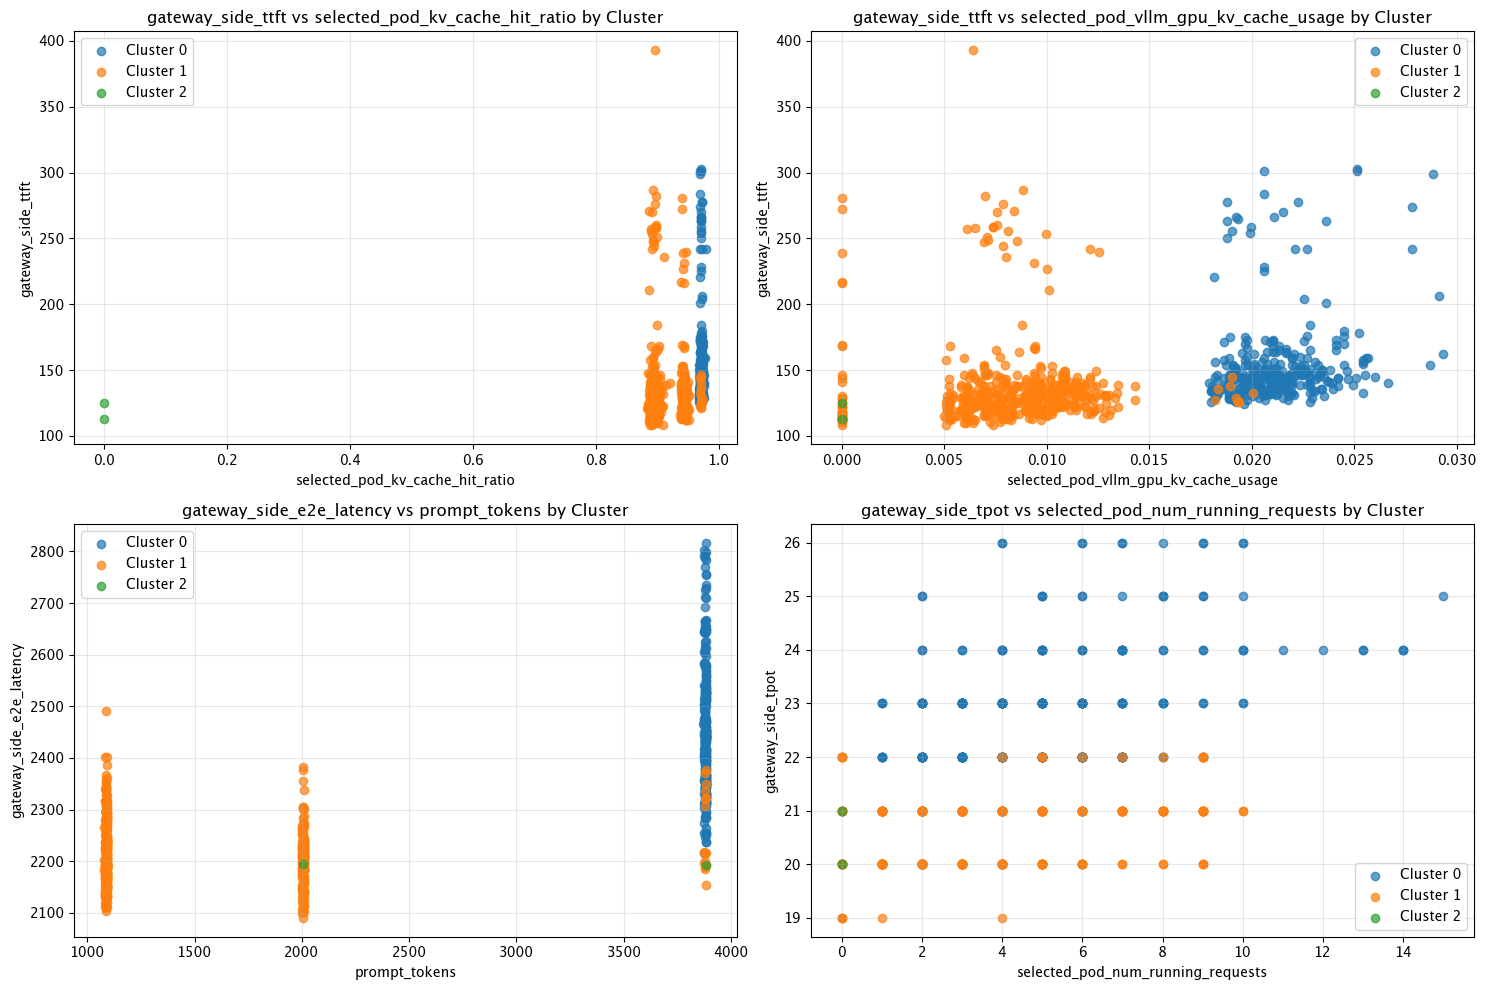

Detected 40 anomalies out of 799 requests (5.0%)

Anomalies vs Normal Requests:
gateway_side_ttft:
  Anomalies: 224.650
  Normal: 139.188
  Percent difference: 61.4%
gateway_side_tpot:
  Anomalies: 22.925
  Normal: 21.265
  Percent difference: 7.8%
gateway_side_e2e_latency:
  Anomalies: 2546.750
  Normal: 2292.744
  Percent difference: 11.1%
selected_pod_kv_cache_hit_ratio:
  Anomalies: 0.954
  Normal: 0.931
  Percent difference: 2.4%
selected_pod_vllm_gpu_kv_cache_usage:
  Anomalies: 0.017
  Normal: 0.013
  Percent difference: 34.7%
selected_pod_num_running_requests:
  Anomalies: 5.775
  Normal: 3.789
  Percent difference: 52.4%
selected_pod_num_waiting_requests:
  Anomalies: 0.025
  Normal: 0.000
  Percent difference: inf%
prompt_tokens:
  Anomalies: 3111.125
  Normal: 2352.383
  Percent difference: 32.3%
output_tokens:
  Anomalies: 100.000
  Normal: 100.000
  Percent difference: 0.0%
total_tokens:
  Anomalies: 3211.125
  Normal: 2452.383
  Percent difference: 30.9%
total_num_infligh

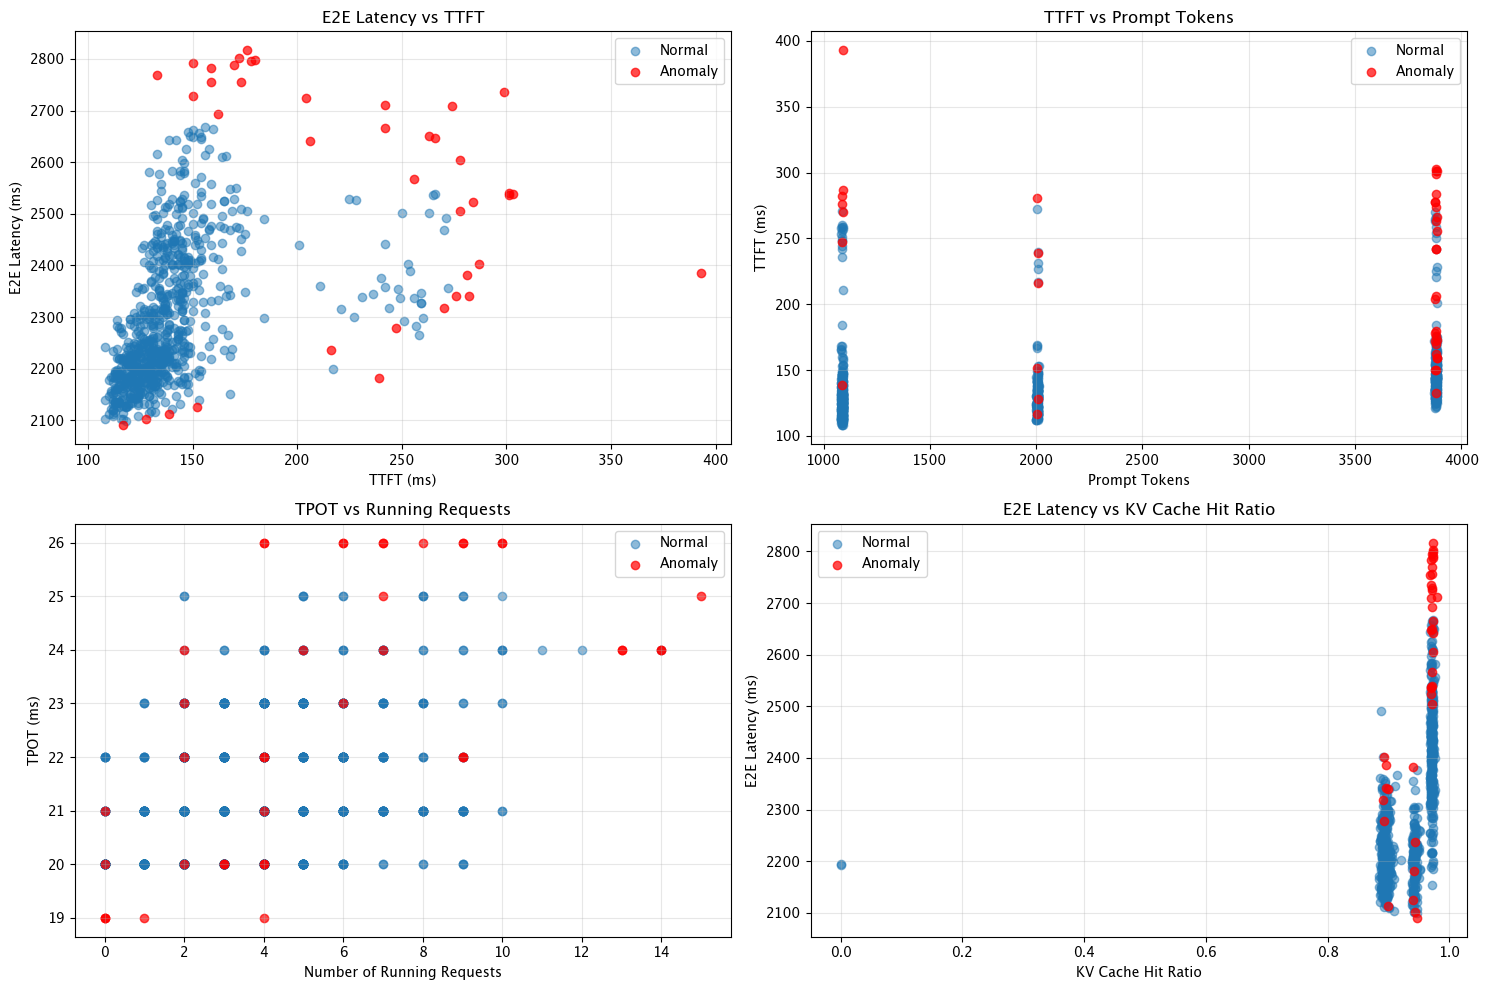


Feature importance for gateway_side_ttft:
selected_pod_vllm_gpu_kv_cache_usage: 0.6894
total_num_inflight_requests: 0.1684
prompt_tokens: 0.1422
output_tokens: 0.0000
selected_pod_num_waiting_requests: 0.0000
selected_pod_num_running_requests: 0.0000
selected_pod_kv_cache_hit_ratio: 0.0000


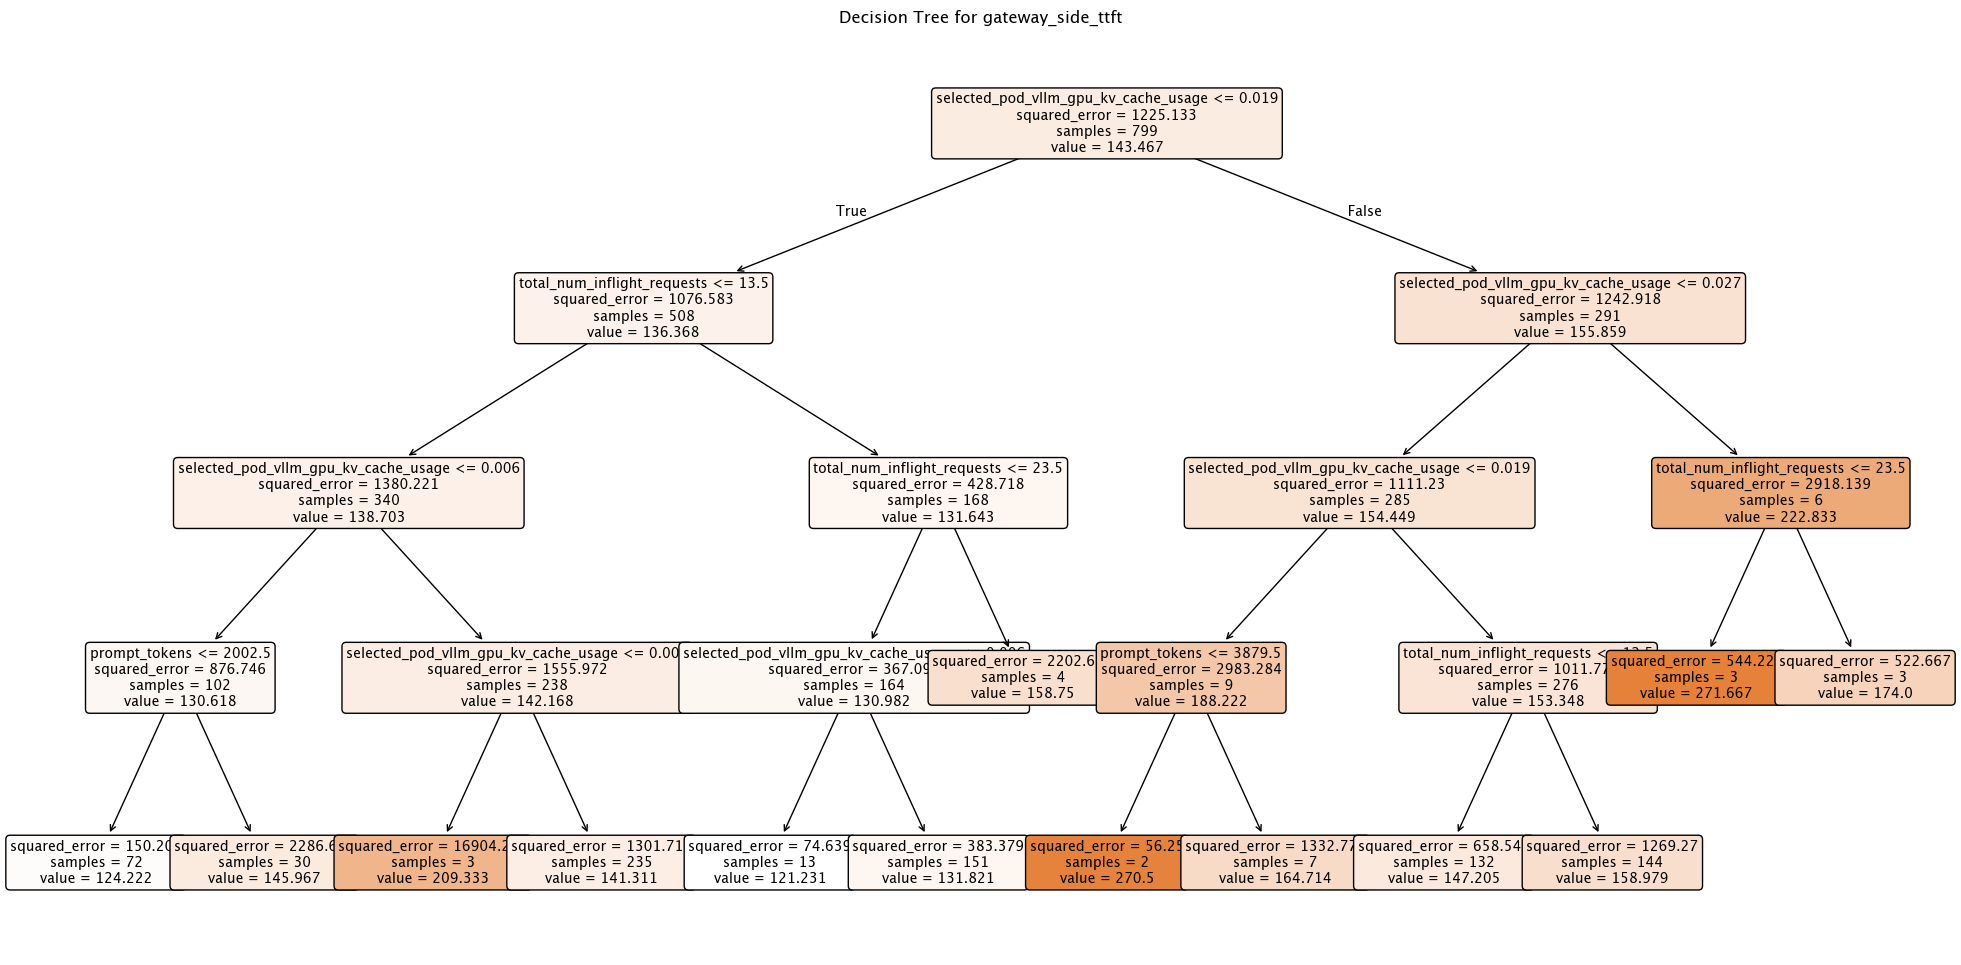


Critical thresholds that affect latency:
When selected_pod_vllm_gpu_kv_cache_usage > 0.019, gateway_side_ttft increases from 136.4 to 155.9 ms (14.3% change)
When prompt_tokens > 2002.500, gateway_side_ttft increases from 124.2 to 146.0 ms (17.5% change)
When selected_pod_vllm_gpu_kv_cache_usage < 0.006, gateway_side_ttft decreases from 141.3 to 209.3 ms (48.1% change)
When total_num_inflight_requests > 23.500, gateway_side_ttft increases from 131.0 to 158.8 ms (21.2% change)
When selected_pod_vllm_gpu_kv_cache_usage > 0.027, gateway_side_ttft increases from 154.4 to 222.8 ms (44.3% change)
When selected_pod_vllm_gpu_kv_cache_usage < 0.019, gateway_side_ttft decreases from 153.3 to 188.2 ms (22.7% change)
When prompt_tokens < 3879.500, gateway_side_ttft decreases from 164.7 to 270.5 ms (64.2% change)
When total_num_inflight_requests < 23.500, gateway_side_ttft decreases from 174.0 to 271.7 ms (56.1% change)

Feature importance for gateway_side_tpot:
selected_pod_vllm_gpu_kv_cache_usag

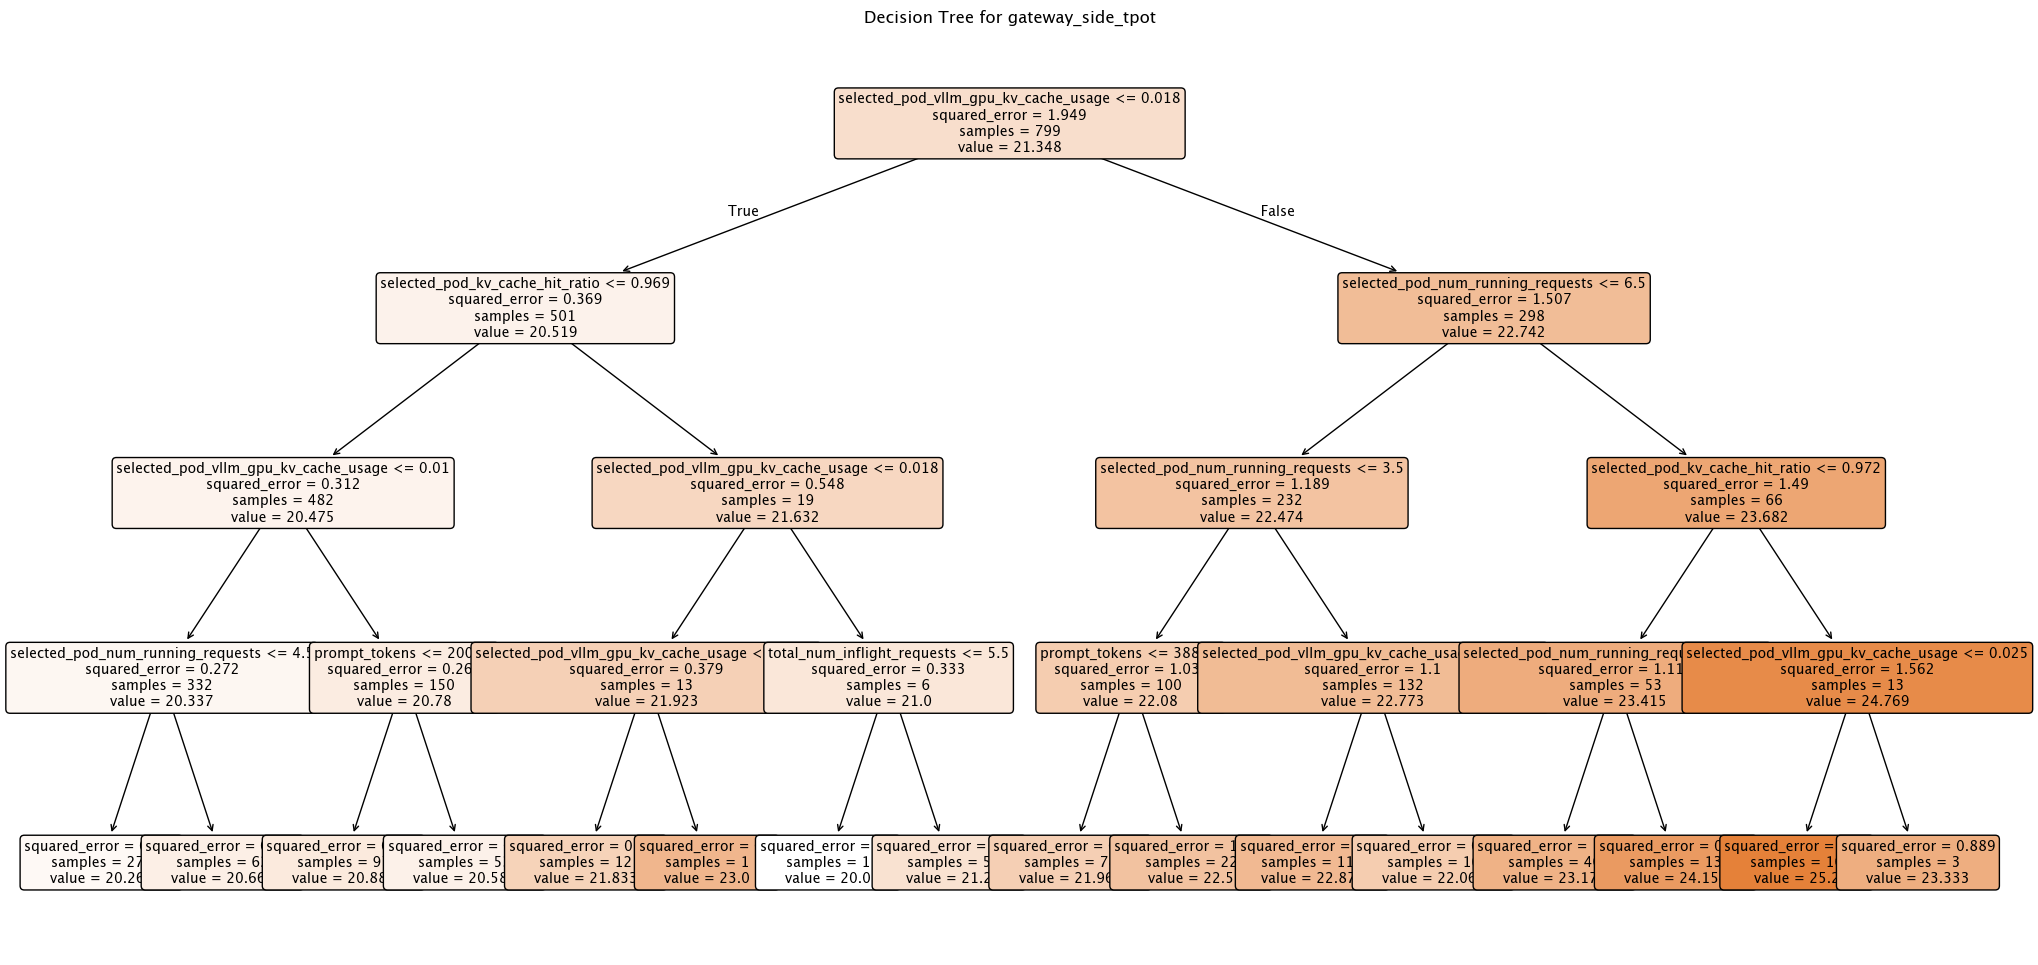


Critical thresholds that affect latency:
When selected_pod_vllm_gpu_kv_cache_usage > 0.018, gateway_side_tpot increases from 20.5 to 22.7 ms (10.8% change)

Feature importance for gateway_side_e2e_latency:
selected_pod_vllm_gpu_kv_cache_usage: 0.8283
selected_pod_num_running_requests: 0.1249
prompt_tokens: 0.0241
selected_pod_kv_cache_hit_ratio: 0.0120
total_num_inflight_requests: 0.0107
output_tokens: 0.0000
selected_pod_num_waiting_requests: 0.0000


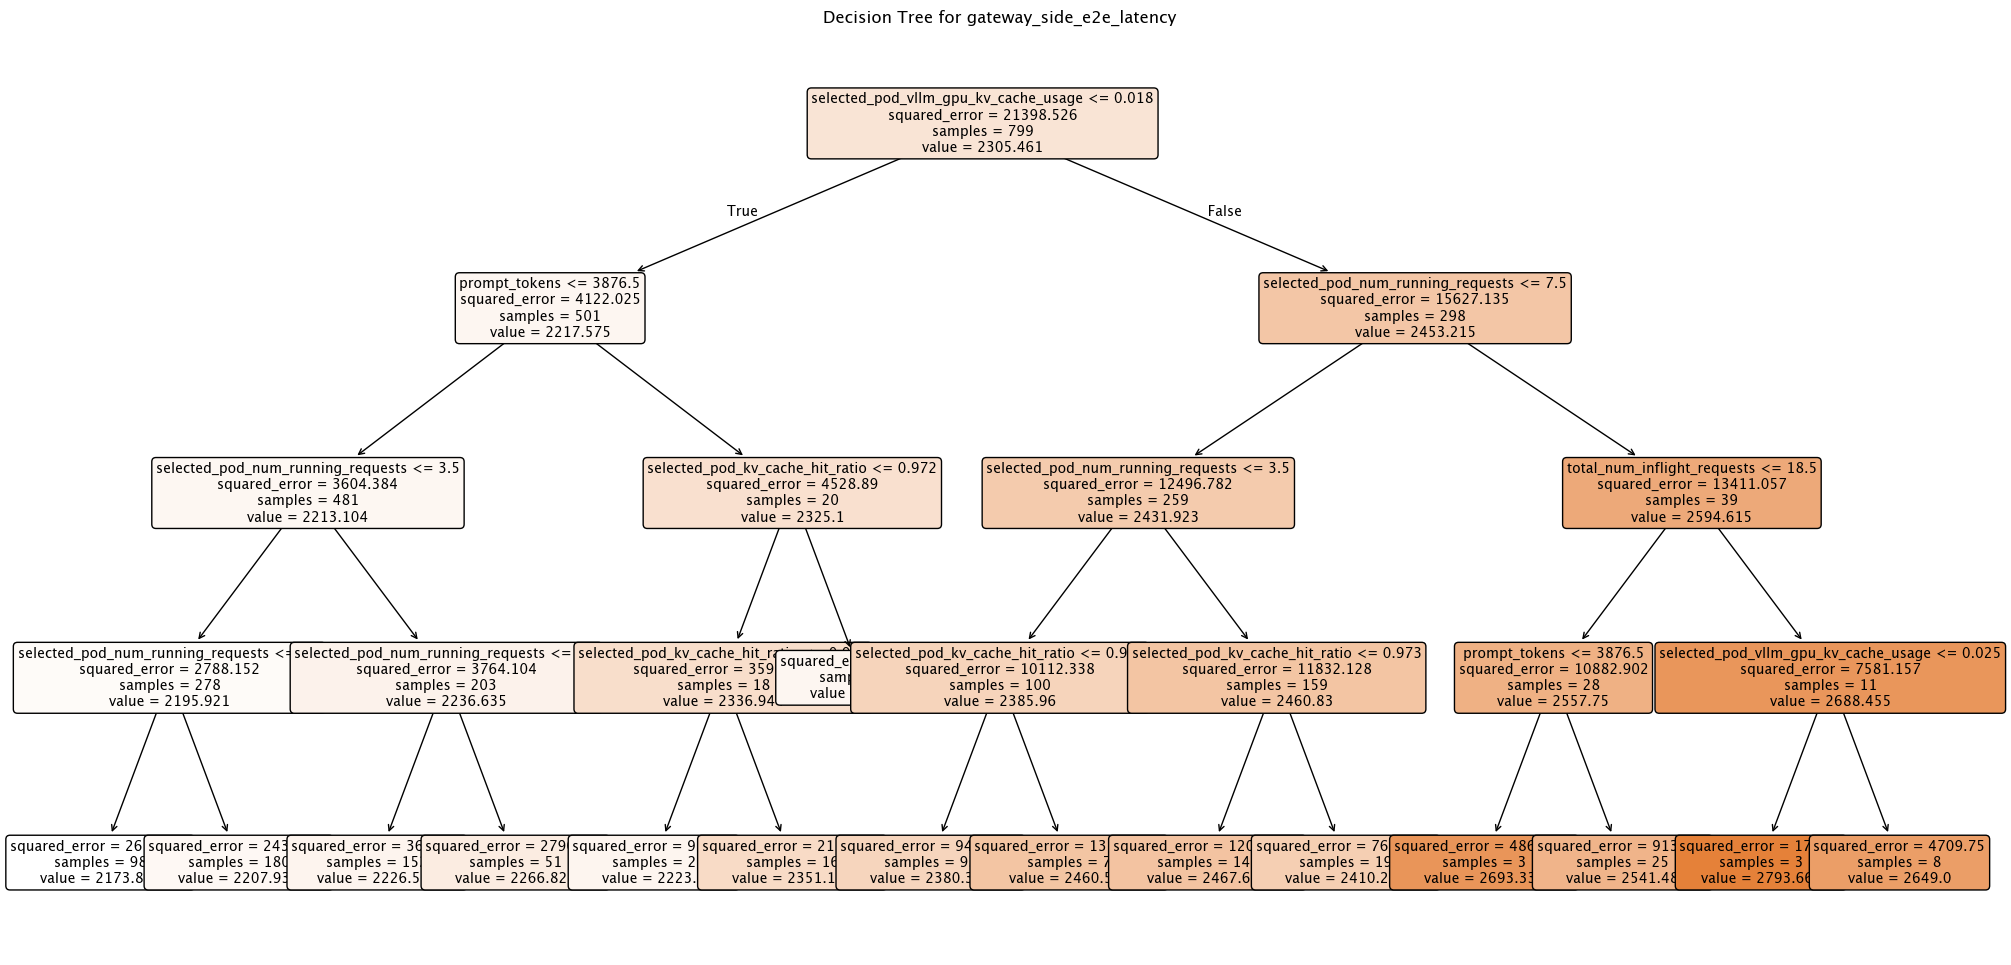


Critical thresholds that affect latency:
When selected_pod_vllm_gpu_kv_cache_usage > 0.018, gateway_side_e2e_latency increases from 2217.6 to 2453.2 ms (10.6% change)

Analysis complete!


In [6]:
def analyze_latency_factors(df):
    """
    Perform statistical analysis to identify factors influencing latency metrics
    """
    # Create a copy to avoid modifying the original
    analysis_df = df.copy()
    
    # 1. Correlation matrix
    latency_cols = ['gateway_side_ttft', 'gateway_side_tpot', 'gateway_side_e2e_latency']
    factor_cols = [
        'selected_pod_kv_cache_hit_ratio', 
        'selected_pod_vllm_gpu_kv_cache_usage',
        'selected_pod_num_running_requests', 
        'selected_pod_num_waiting_requests',
        'prompt_tokens', 
        'output_tokens', 
        'total_tokens',
        'total_num_inflight_requests'
    ]
    
    all_cols = latency_cols + factor_cols
    correlation_matrix = analysis_df[all_cols].corr()
    
    # Display correlations with latency metrics
    print("CORRELATIONS WITH LATENCY METRICS")
    for latency_col in latency_cols:
        print(f"\n{latency_col} correlations:")
        correlations = correlation_matrix[latency_col].sort_values(ascending=False)
        for col, corr in correlations.items():
            if col != latency_col and col in factor_cols:
                print(f"{col}: {corr:.3f}")
    
    # 2. Threshold analysis - identify when latency spikes
    print("\nTHRESHOLD ANALYSIS")
    for latency_col in latency_cols:
        # Calculate percentiles
        p50 = analysis_df[latency_col].quantile(0.5)
        p75 = analysis_df[latency_col].quantile(0.75)
        p90 = analysis_df[latency_col].quantile(0.9)
        p95 = analysis_df[latency_col].quantile(0.95)
        
        print(f"\n{latency_col} thresholds:")
        print(f"50th percentile: {p50:.2f} ms")
        print(f"75th percentile: {p75:.2f} ms")
        print(f"90th percentile: {p90:.2f} ms")
        print(f"95th percentile: {p95:.2f} ms")
        
        # Analyze high latency samples (above 90th percentile)
        high_latency = analysis_df[analysis_df[latency_col] > p90]
        normal_latency = analysis_df[analysis_df[latency_col] <= p90]
        
        print(f"\nFactor comparison for high vs normal {latency_col}:")
        for factor in factor_cols:
            if factor in analysis_df.columns:
                high_mean = high_latency[factor].mean()
                normal_mean = normal_latency[factor].mean()
                percent_diff = ((high_mean - normal_mean) / normal_mean * 100) if normal_mean != 0 else float('inf')
                
                print(f"{factor}:")
                print(f"  High latency mean: {high_mean:.3f}")
                print(f"  Normal latency mean: {normal_mean:.3f}")
                print(f"  Percent difference: {percent_diff:.1f}%")
    
    # 3. Time series analysis - check if latency increases over time
    print("\nTIME SERIES ANALYSIS")
    analysis_df.sort_values('normalized_start_time', inplace=True)
    
    # Create time buckets (every 10 seconds)
    bucket_size = 10
    analysis_df['time_bucket'] = (analysis_df['normalized_start_time'] / bucket_size).astype(int) * bucket_size
    
    # Group by time bucket and get means
    time_trends = analysis_df.groupby('time_bucket')[latency_cols + factor_cols].mean()
    
    # Calculate rolling correlations between factors and latency over time
    window_size = 5  # 5 time buckets
    if len(time_trends) > window_size:
        print("\nRolling correlations over time (shows how relationships change):")
        for latency_col in latency_cols:
            print(f"\n{latency_col} rolling correlations:")
            for factor in factor_cols:
                if factor in time_trends.columns:
                    rolling_corr = time_trends[latency_col].rolling(window=window_size).corr(time_trends[factor])
                    if not rolling_corr.isnull().all():
                        print(f"{factor}: Initial: {rolling_corr.iloc[window_size]:.3f}, "
                              f"Final: {rolling_corr.iloc[-1]:.3f}, "
                              f"Mean: {rolling_corr.mean():.3f}")
    
    # 4. Multiple regression analysis
    print("\nMULTIPLE REGRESSION ANALYSIS")
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import StandardScaler
    
    for latency_col in latency_cols:
        # Prepare data
        X = analysis_df[factor_cols].fillna(0)
        y = analysis_df[latency_col]
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Fit regression model
        model = LinearRegression()
        model.fit(X_scaled, y)
        
        # Print coefficients
        print(f"\n{latency_col} regression coefficients (higher = more impact):")
        coeffs = list(zip(factor_cols, model.coef_))
        coeffs.sort(key=lambda x: abs(x[1]), reverse=True)
        
        for factor, coeff in coeffs:
            print(f"{factor}: {coeff:.3f}")
        
        # Model performance
        r2 = model.score(X_scaled, y)
        print(f"R² score: {r2:.3f}")
    
    return correlation_matrix, time_trends

def create_latency_distribution_cluster_analysis(df):
    """
    Perform cluster analysis to identify patterns in latency behavior
    """
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    
    # Features to use for clustering
    features = [
        'gateway_side_ttft', 
        'gateway_side_tpot', 
        'gateway_side_e2e_latency',
        'selected_pod_kv_cache_hit_ratio', 
        'selected_pod_vllm_gpu_kv_cache_usage',
        'selected_pod_num_running_requests',
        'prompt_tokens',
        'output_tokens'
    ]
    
    # Prepare data
    cluster_df = df[features].copy()
    cluster_df = cluster_df.fillna(0)
    
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(cluster_df)
    
    # Determine optimal number of clusters using the elbow method
    wcss = []
    max_clusters = min(10, len(df) - 1)  # Up to 10 clusters or dataset size - 1
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
        kmeans.fit(scaled_features)
        wcss.append(kmeans.inertia_)
    
    # Plot the elbow curve
    plt.figure()
    plt.plot(range(1, max_clusters + 1), wcss, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.grid(True)
    plt.show()
    
    # Use 3 clusters or determine from elbow plot
    n_clusters = 3
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df['cluster'] = kmeans.fit_predict(scaled_features)
    
    # Analyze clusters
    print(f"CLUSTER ANALYSIS WITH {n_clusters} CLUSTERS")
    cluster_stats = df.groupby('cluster')[features].mean()
    print("\nCluster centers:")
    print(cluster_stats)
    
    # Calculate the percentage difference from overall mean
    overall_mean = df[features].mean()
    for cluster in range(n_clusters):
        print(f"\nCluster {cluster} characteristics:")
        for feature in features:
            cluster_mean = cluster_stats.loc[cluster, feature]
            percent_diff = ((cluster_mean - overall_mean[feature]) / overall_mean[feature] * 100) if overall_mean[feature] != 0 else float('inf')
            print(f"{feature}: {percent_diff:.1f}% {'higher' if percent_diff > 0 else 'lower'} than average")
    
    # Plot the clusters
    plt.figure(figsize=(15, 10))
    
    # Create a 2x2 grid of important plots
    plot_features = [
        ('selected_pod_kv_cache_hit_ratio', 'gateway_side_ttft'),
        ('selected_pod_vllm_gpu_kv_cache_usage', 'gateway_side_ttft'),
        ('prompt_tokens', 'gateway_side_e2e_latency'),
        ('selected_pod_num_running_requests', 'gateway_side_tpot')
    ]
    
    for i, (x_feature, y_feature) in enumerate(plot_features):
        plt.subplot(2, 2, i+1)
        for cluster in range(n_clusters):
            cluster_data = df[df['cluster'] == cluster]
            plt.scatter(
                cluster_data[x_feature], 
                cluster_data[y_feature], 
                alpha=0.7, 
                label=f'Cluster {cluster}'
            )
        
        plt.title(f'{y_feature} vs {x_feature} by Cluster')
        plt.xlabel(x_feature)
        plt.ylabel(y_feature)
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return df['cluster'], cluster_stats

def create_anomaly_detection(df):
    """
    Perform anomaly detection to identify outliers in latency metrics
    """
    from sklearn.ensemble import IsolationForest
    import matplotlib.pyplot as plt
    
    # Features to use for anomaly detection
    features = [
        'gateway_side_ttft', 
        'gateway_side_tpot', 
        'gateway_side_e2e_latency'
    ]
    
    # Prepare data
    anomaly_df = df[features].copy()
    anomaly_df = anomaly_df.fillna(0)
    
    # Use Isolation Forest for anomaly detection
    isolation_forest = IsolationForest(
        n_estimators=100,
        max_samples='auto',
        contamination=0.05,  # 5% of data are anomalies
        random_state=42
    )
    
    # Fit and predict
    df['anomaly'] = isolation_forest.fit_predict(anomaly_df)
    # Convert to boolean (1 = normal, -1 = anomaly)
    df['anomaly'] = df['anomaly'] == -1
    
    # Get anomalies
    anomalies = df[df['anomaly'] == True]
    print(f"Detected {len(anomalies)} anomalies out of {len(df)} requests ({len(anomalies)/len(df)*100:.1f}%)")
    
    # Analyze what makes anomalies different
    factor_cols = [
        'selected_pod_kv_cache_hit_ratio', 
        'selected_pod_vllm_gpu_kv_cache_usage',
        'selected_pod_num_running_requests', 
        'selected_pod_num_waiting_requests',
        'prompt_tokens', 
        'output_tokens', 
        'total_tokens',
        'total_num_inflight_requests'
    ]
    
    print("\nAnomalies vs Normal Requests:")
    anomaly_stats = df.groupby('anomaly')[features + factor_cols].mean()
    
    for col in features + factor_cols:
        if col in anomaly_stats.columns:
            anomaly_value = anomaly_stats.loc[True, col] if True in anomaly_stats.index else 0
            normal_value = anomaly_stats.loc[False, col] if False in anomaly_stats.index else 0
            pct_diff = ((anomaly_value - normal_value) / normal_value * 100) if normal_value != 0 else float('inf')
            
            print(f"{col}:")
            print(f"  Anomalies: {anomaly_value:.3f}")
            print(f"  Normal: {normal_value:.3f}")
            print(f"  Percent difference: {pct_diff:.1f}%")
    
    # Visualize anomalies
    plt.figure(figsize=(15, 10))
    
    # 3 different plots
    plt.subplot(2, 2, 1)
    plt.scatter(
        df[~df['anomaly']]['gateway_side_ttft'], 
        df[~df['anomaly']]['gateway_side_e2e_latency'],
        alpha=0.5, 
        label='Normal'
    )
    plt.scatter(
        df[df['anomaly']]['gateway_side_ttft'], 
        df[df['anomaly']]['gateway_side_e2e_latency'],
        color='red', 
        alpha=0.7, 
        label='Anomaly'
    )
    plt.title('E2E Latency vs TTFT')
    plt.xlabel('TTFT (ms)')
    plt.ylabel('E2E Latency (ms)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 2)
    plt.scatter(
        df[~df['anomaly']]['prompt_tokens'], 
        df[~df['anomaly']]['gateway_side_ttft'],
        alpha=0.5, 
        label='Normal'
    )
    plt.scatter(
        df[df['anomaly']]['prompt_tokens'], 
        df[df['anomaly']]['gateway_side_ttft'],
        color='red', 
        alpha=0.7, 
        label='Anomaly'
    )
    plt.title('TTFT vs Prompt Tokens')
    plt.xlabel('Prompt Tokens')
    plt.ylabel('TTFT (ms)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 3)
    plt.scatter(
        df[~df['anomaly']]['selected_pod_num_running_requests'], 
        df[~df['anomaly']]['gateway_side_tpot'],
        alpha=0.5, 
        label='Normal'
    )
    plt.scatter(
        df[df['anomaly']]['selected_pod_num_running_requests'], 
        df[df['anomaly']]['gateway_side_tpot'],
        color='red', 
        alpha=0.7, 
        label='Anomaly'
    )
    plt.title('TPOT vs Running Requests')
    plt.xlabel('Number of Running Requests')
    plt.ylabel('TPOT (ms)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 4)
    plt.scatter(
        df[~df['anomaly']]['selected_pod_kv_cache_hit_ratio'], 
        df[~df['anomaly']]['gateway_side_e2e_latency'],
        alpha=0.5, 
        label='Normal'
    )
    plt.scatter(
        df[df['anomaly']]['selected_pod_kv_cache_hit_ratio'], 
        df[df['anomaly']]['gateway_side_e2e_latency'],
        color='red', 
        alpha=0.7, 
        label='Anomaly'
    )
    plt.title('E2E Latency vs KV Cache Hit Ratio')
    plt.xlabel('KV Cache Hit Ratio')
    plt.ylabel('E2E Latency (ms)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return df['anomaly']

def create_latency_factor_decision_tree(df):
    """
    Use decision trees to identify critical thresholds for latency increases
    """
    from sklearn.tree import DecisionTreeRegressor, plot_tree
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Features that might impact latency
    features = [
        'selected_pod_kv_cache_hit_ratio', 
        'selected_pod_vllm_gpu_kv_cache_usage',
        'selected_pod_num_running_requests', 
        'selected_pod_num_waiting_requests',
        'prompt_tokens', 
        'output_tokens',
        'total_num_inflight_requests'
    ]
    
    # Prepare data
    X = df[features].fillna(0)
    
    # Analyze each latency metric
    for target in ['gateway_side_ttft', 'gateway_side_tpot', 'gateway_side_e2e_latency']:
        y = df[target]
        
        # Train a decision tree
        tree = DecisionTreeRegressor(
            max_depth=4,  # Limit depth for interpretability
            min_samples_split=5,
            random_state=42
        )
        tree.fit(X, y)
        
        # Calculate feature importance
        importance = tree.feature_importances_
        
        # Sort features by importance
        indices = np.argsort(importance)[::-1]
        
        print(f"\nFeature importance for {target}:")
        for i in range(len(indices)):
            print(f"{features[indices[i]]}: {importance[indices[i]]:.4f}")
        
        # Plot the decision tree
        plt.figure(figsize=(25, 12))
        plot_tree(
            tree, 
            feature_names=features,
            filled=True, 
            rounded=True, 
            fontsize=10
        )
        plt.title(f'Decision Tree for {target}')
        plt.show()
        
        # Find critical thresholds from the tree
        print("\nCritical thresholds that affect latency:")
        
        # Extract thresholds from tree structure
        n_nodes = tree.tree_.node_count
        children_left = tree.tree_.children_left
        children_right = tree.tree_.children_right
        feature = tree.tree_.feature
        threshold = tree.tree_.threshold
        value = tree.tree_.value
        
        for i in range(n_nodes):
            # If not a leaf node
            if children_left[i] != children_right[i]:
                node_feature = features[feature[i]]
                node_threshold = threshold[i]
                
                left_value = value[children_left[i]][0][0]
                right_value = value[children_right[i]][0][0]
                
                # Only show significant splits (at least 10% difference)
                if abs(left_value - right_value) > y.mean() * 0.1:
                    direction = ">" if right_value > left_value else "<"
                    print(f"When {node_feature} {direction} {node_threshold:.3f}, "
                          f"{target} {'increases' if direction == '>' else 'decreases'} "
                          f"from {min(left_value, right_value):.1f} to {max(left_value, right_value):.1f} ms "
                          f"({abs(right_value - left_value) / min(left_value, right_value) * 100:.1f}% change)")
    
    return None


"""
Main function to run all analyses
"""
print("Starting comprehensive latency analysis...")

# Fill any NaN values for analysis
df = df.fillna(0)

# 1. Basic correlation analysis
correlation_matrix, time_trends = analyze_latency_factors(df)

# 2. Cluster analysis
clusters, cluster_stats = create_latency_distribution_cluster_analysis(df)

# 3. Anomaly detection
anomalies = create_anomaly_detection(df)

# 4. Decision tree analysis for thresholds
create_latency_factor_decision_tree(df)

print("\nAnalysis complete!")
